In [ ]:
pip install cma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 5.0 MB/s eta 0:00:00


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:55:06 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -1.205561248416842e-02 1.0e+00 1.78e-01  2e-01  2e-01 0:00.1
    2     16 -9.998120739002303e-03 1.1e+00 1.56e-01  1e-01  2e-01 0:00.1
    3     24 -9.998120739002303e-03 1.3e+00 1.50e-01  1e-01  1e-01 0:00.1
    4     32 -9.998120739002303e-03 1.3e+00 1.41e-01  1e-01  1e-01 0:00.2
termination on tolflatfitness=1 (Tue Jul 22 12:55:06 2025)
final/bestever f-value = -9.998121e-03 -1.205561e-02 after 33/1 evaluations
incumbent solution: [ 0.31590449, -0.04909103, 0.04118488, -0.04839484, 0.00552435]
std deviation: [0.14594795, 0.12267427, 0.12276597, 0.13515398, 0.12102708]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:55:06 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -1.291500981654004e-02 1.0e+00 1.74e-01  2e-01  2e-01 0:00.0
    2     16 -1.291

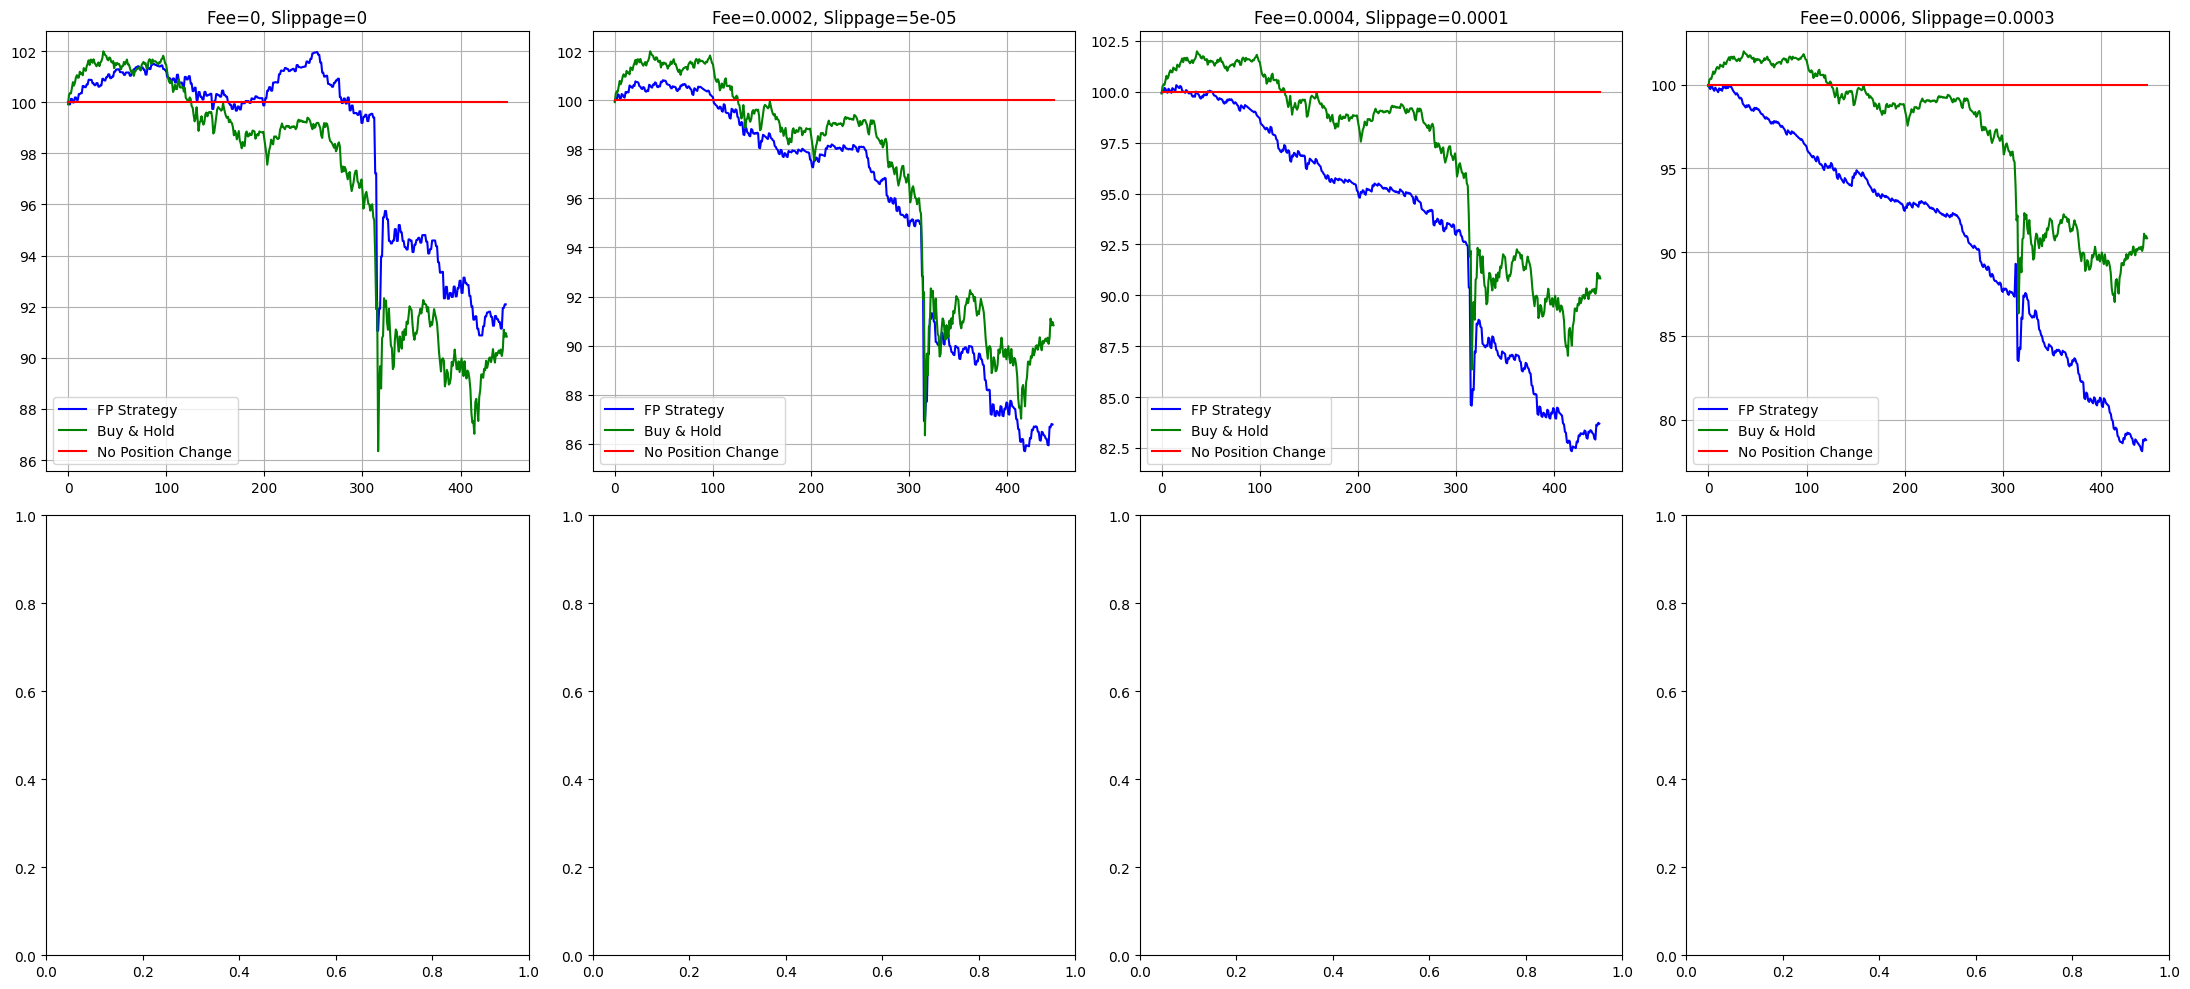


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            92.09          -7.91           90.83                  -9.17    100.0             0.0
0.0002   0.00005            86.79         -13.21           90.83                  -9.17    100.0             0.0
0.0004   0.00010            83.69         -16.31           90.83                  -9.17    100.0             0.0
0.0006   0.00030            78.79         -21.21           90.83                  -9.17    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("BTC_5min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']
bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

df_train['log_mid'] = np.log(df_train['midpoint'])
df_train['returns'] = df_train['log_mid'].diff().fillna(0)
df_cv['log_mid'] = np.log(df_cv['midpoint'])
df_cv['returns'] = df_cv['log_mid'].diff().fillna(0)
df_test['log_mid'] = np.log(df_test['midpoint'])
df_test['returns'] = df_test['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, obi, timesteps, dt):
    a0, a1, a2 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        mu = a0 + a1 * x[t-1] + a2 * obi[t-1]
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    obi = df_slice['obi'].values
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:3]
        sigma_params = params[3:]
        signal = simulate_fp(mu_params, sigma_params, x_init, obi, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0, 0, 0, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed})
    return res[0][:3], res[0][3:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(0, 200), (200, 400), (400, 600), (600, 800), (800, 1000)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        if end > len(df_train):
            continue
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end]['obi'].values, end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    cv_obi = df_cv['obi'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, cv_obi[start:end], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_obi = df_test['obi'].values
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_obi[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        raise ValueError("No positions generated.")

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:57:24 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -2.441963413058090e-02 1.0e+00 2.01e-01  2e-01  2e-01 0:00.0
    2     16 -4.169058070135634e-02 1.4e+00 2.08e-01  2e-01  2e-01 0:00.1
    3     24 -3.684787103446929e-02 1.4e+00 2.07e-01  2e-01  2e-01 0:00.1
   75    600 -6.203562239241656e-02 5.5e+01 2.58e-01  9e-02  3e-01 0:02.0
termination on tolflatfitness=1 (Tue Jul 22 12:57:27 2025)
final/bestever f-value = -6.203562e-02 -6.423332e-02 after 601/164 evaluations
incumbent solution: [-4.20007249, 1.42307344, 0.96444844, 1.9999852, -3.6050374, ]
std deviation: [0.29951799, 0.09296883, 0.12113019, 0.30080589, 0.13899404]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:57:27 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -2.545676823044296e-02 1.0e+00 1.78e-01  2e-01  2e-01 0:00.0
    2     16 -3.2

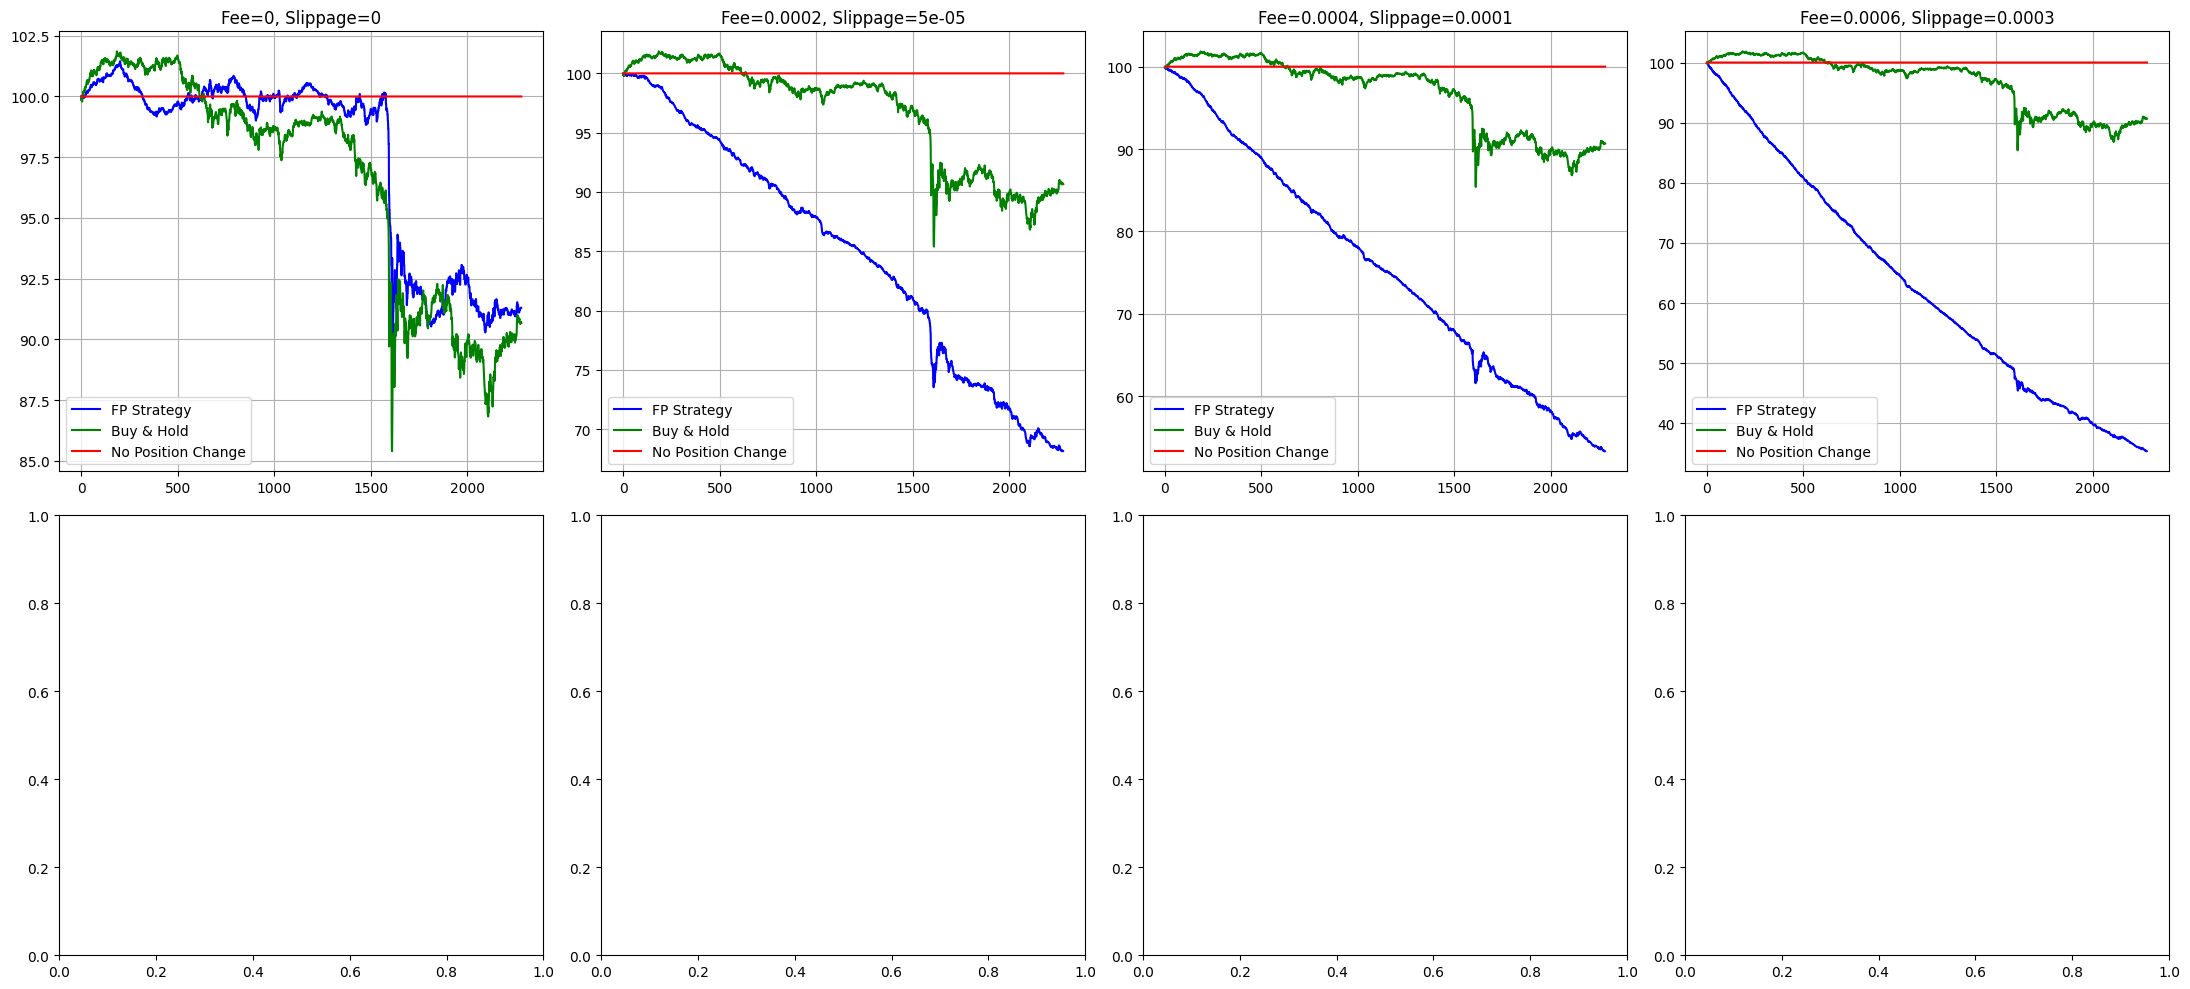


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            91.30          -8.70           90.67                  -9.33    100.0             0.0
0.0002   0.00005            68.15         -31.85           90.67                  -9.33    100.0             0.0
0.0004   0.00010            53.32         -46.68           90.67                  -9.33    100.0             0.0
0.0006   0.00030            35.38         -64.62           90.67                  -9.33    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("BTC_1min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']
bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

df_train['log_mid'] = np.log(df_train['midpoint'])
df_train['returns'] = df_train['log_mid'].diff().fillna(0)
df_cv['log_mid'] = np.log(df_cv['midpoint'])
df_cv['returns'] = df_cv['log_mid'].diff().fillna(0)
df_test['log_mid'] = np.log(df_test['midpoint'])
df_test['returns'] = df_test['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, obi, timesteps, dt):
    a0, a1, a2 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        mu = a0 + a1 * x[t-1] + a2 * obi[t-1]
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    obi = df_slice['obi'].values
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:3]
        sigma_params = params[3:]
        signal = simulate_fp(mu_params, sigma_params, x_init, obi, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0, 0, 0, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed})
    return res[0][:3], res[0][3:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(0, 500), (500, 1000), (1000, 1500), (1500, 2000), (2000, 2500)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        if end > len(df_train):
            continue
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end]['obi'].values, end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    cv_obi = df_cv['obi'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, cv_obi[start:end], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_obi = df_test['obi'].values
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_obi[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        raise ValueError("No positions generated.")

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:58:30 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -1.526229089390085e-02 1.0e+00 1.75e-01  2e-01  2e-01 0:00.2


/tmp/ipython-input-4-1455862918.py:55: RuntimeWarning: overflow encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
/tmp/ipython-input-4-1455862918.py:55: RuntimeWarning: invalid value encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()


    2     16 -1.641531617207015e-02 1.2e+00 1.85e-01  2e-01  2e-01 0:00.4
    3     24 -1.824139523899682e-02 1.3e+00 1.96e-01  2e-01  2e-01 0:00.7


/tmp/ipython-input-4-1455862918.py:53: RuntimeWarning: overflow encountered in scalar multiply
  mu = a0 + a1 * x[t-1] + a2 * obi[t-1]


   16    128 -6.310840890263769e-02 3.0e+00 3.43e-01  2e-01  4e-01 0:03.7
   27    216 -7.523560598786716e-02 4.2e+00 1.49e-01  7e-02  2e-01 0:07.8
   49    392 -7.995890086868584e-02 8.9e+00 3.11e-02  9e-03  4e-02 0:12.9
   73    584 -8.118571258484053e-02 1.7e+01 6.57e-03  9e-04  7e-03 0:19.0
   92    736 -8.126575128741287e-02 1.1e+01 2.36e-03  2e-04  1e-03 0:24.0
termination on tolflatfitness=1 (Tue Jul 22 12:58:54 2025)
final/bestever f-value = -8.126575e-02 -8.126575e-02 after 737/628 evaluations
incumbent solution: [ 0.58209795, -1.66012098, 1.98540641, 0.10691739, 0.03120231]
std deviation: [0.00057081, 0.00020772, 0.00148053, 0.00027078, 0.00038028]
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=42, Tue Jul 22 12:58:54 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -2.667937332978454e-02 1.0e+00 1.93e-01  2e-01  2e-01 0:00.2
    2     16 -3.127055706997339e-02 1.3e+00 2.33e-01  2e-01  2e-01 0:00.5
    3     24 -3.78527572309

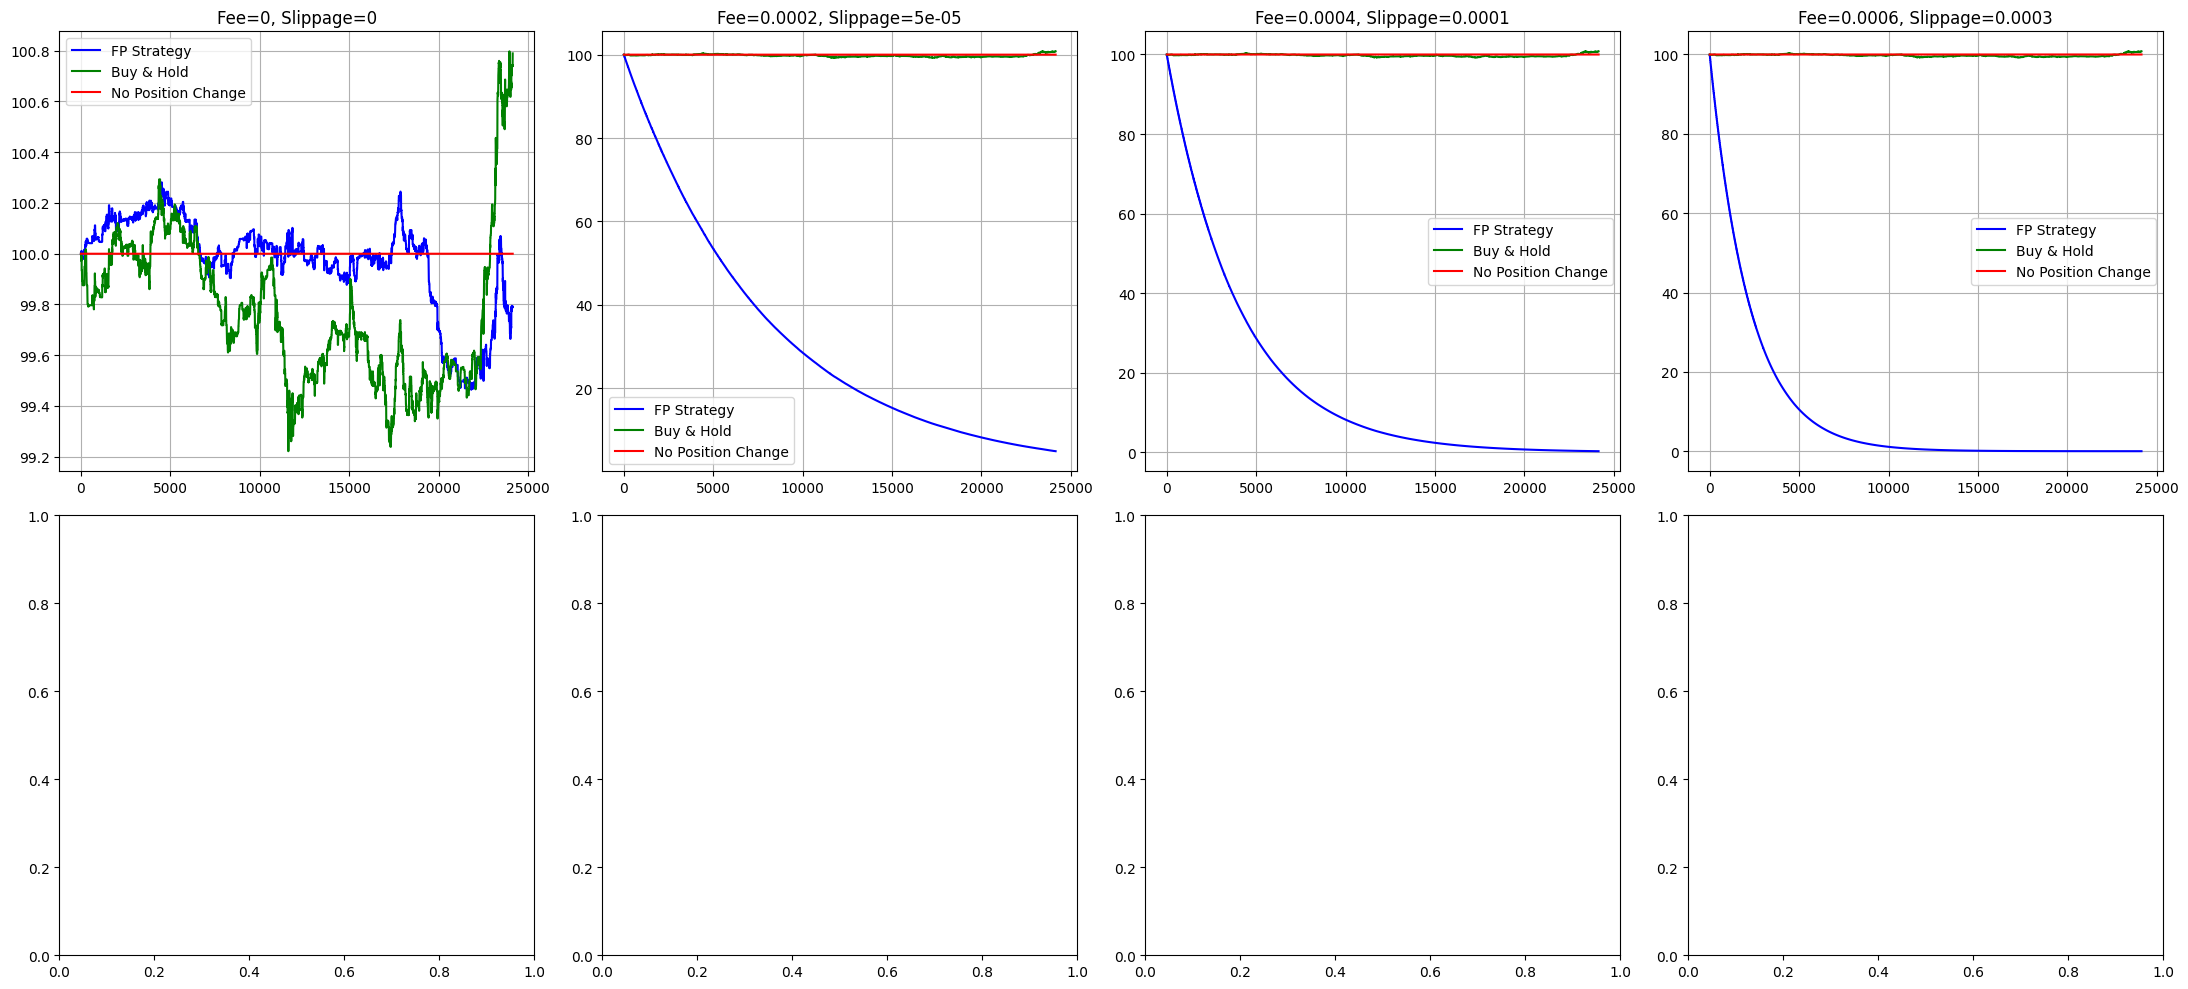


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            99.79          -0.21          100.79                   0.79    100.0             0.0
0.0002   0.00005             4.91         -95.09          100.79                   0.79    100.0             0.0
0.0004   0.00010             0.24         -99.76          100.79                   0.79    100.0             0.0
0.0006   0.00030             0.00        -100.00          100.79                   0.79    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("BTC_1sec.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']
bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

df_train['log_mid'] = np.log(df_train['midpoint'])
df_train['returns'] = df_train['log_mid'].diff().fillna(0)
df_cv['log_mid'] = np.log(df_cv['midpoint'])
df_cv['returns'] = df_cv['log_mid'].diff().fillna(0)
df_test['log_mid'] = np.log(df_test['midpoint'])
df_test['returns'] = df_test['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, obi, timesteps, dt):
    a0, a1, a2 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        mu = a0 + a1 * x[t-1] + a2 * obi[t-1]
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    obi = df_slice['obi'].values
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:3]
        sigma_params = params[3:]
        signal = simulate_fp(mu_params, sigma_params, x_init, obi, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0, 0, 0, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed})
    return res[0][:3], res[0][3:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(0, 5000), (5000, 10000), (10000, 15000), (15000, 20000), (20000, 25000)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        if end > len(df_train):
            continue
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end]['obi'].values, end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    cv_obi = df_cv['obi'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, cv_obi[start:end], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_obi = df_test['obi'].values
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_obi[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        raise ValueError("No positions generated.")

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 7 (seed=42, Tue Jul 22 17:28:33 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 -1.865589331754940e-02 1.0e+00 2.28e-01  2e-01  3e-01 0:04.5
    2     40 -9.881547612215692e-03 1.5e+00 2.48e-01  2e-01  3e-01 0:04.5
    3     60 -1.537656772190879e-02 1.8e+00 2.84e-01  3e-01  3e-01 0:04.5
  100   2000 -1.306173577874299e-02 1.9e+01 3.76e-01  9e-02  2e-01 0:04.9
  200   4000 -1.345685209424963e-02 8.4e+01 4.99e-01  4e-02  2e-01 0:05.3
  300   6000 -1.347989566576635e-02 1.3e+02 1.89e-01  4e-03  3e-02 0:05.6
  335   6700 -1.347989566576635e-02 1.2e+02 6.41e-02  1e-03  7e-03 0:05.7
termination on tolfunhist=1e-12 (Tue Jul 22 17:28:39 2025)
final/bestever f-value = -1.346710e-02 -1.865589e-02 after 6701/11 evaluations
incumbent solution: [ 1.77788044, -1.63571475, 2.44848813, 1.19564384, -2.36130106, -0.3517948, -1.88996694]
std deviation: [0.00474003, 0.00099089, 0.00619454, 0.0020067, 0.00295947, 

/tmp/ipython-input-2-2243444373.py:103: RuntimeWarning: overflow encountered in square
  volatility = np.sqrt(np.mean(np.diff(signal)**2))


  200   4000 -2.341191048233586e-02 2.4e+02 3.76e-01  1e-02  6e-01 0:00.6
  300   6000 -2.063727277544291e-02 1.8e+03 9.90e-02  2e-03  1e-01 0:00.9
  400   8000 -1.912161541608984e-02 4.3e+03 1.10e-01  2e-03  9e-02 0:01.2
  500  10000 -1.974059151709575e-02 4.3e+04 4.18e-01  8e-03  4e-01 0:01.5
  560  11200 -2.015998435578581e-02 1.8e+05 3.37e-01  9e-03  5e-01 0:01.6
termination on tolstagnation=192 (Tue Jul 22 17:28:47 2025)
final/bestever f-value = -2.111056e-03 -3.218309e-02 after 11201/2393 evaluations
incumbent solution: [-0.02537601, -0.65905462, 0.92710548, 0.66472522, -0.91211019, -2.38329023, 0.64913239]
std deviation: [0.00920291, 0.04820588, 0.0132609, 0.05700696, 0.2917268, 0.18266776, 0.48063158]
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 7 (seed=42, Tue Jul 22 17:28:47 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 -3.747889238525293e-02 1.0e+00 2.06e-01  2e-01  2e-01 0:00.0
    2     40 -3.779090058354680e-02 1.4e+00 2.2

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


    2     40 -3.768212498877268e-02 1.3e+00 1.67e-01  1e-01  2e-01 0:00.0
    3     60 -2.822935816103023e-02 1.3e+00 1.60e-01  1e-01  2e-01 0:00.0
   91   1820 -4.139052382129690e-02 1.1e+03 1.50e-01  4e-03  3e-01 0:00.3
termination on tolfunhist=1e-12 (Tue Jul 22 17:28:48 2025)
final/bestever f-value = -4.139052e-02 -4.251968e-02 after 1821/138 evaluations
incumbent solution: [-0.80092877, -0.10572393, 5.12763849, -0.04080604, -0.25388465, -2.03484853, -2.40614098]
std deviation: [0.02506752, 0.00386756, 0.15965646, 0.0208356, 0.26915238, 0.14894375, 0.1895651, ]
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 7 (seed=42, Tue Jul 22 17:28:48 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 -1.024379769299004e-02 1.0e+00 2.37e-01  2e-01  3e-01 0:00.6
    2     40 -8.057105655962312e-03 1.4e+00 2.82e-01  2e-01  3e-01 0:00.6
    3     60 -8.117880697337751e-03 1.6e+00 3.15e-01  3e-01  4e-01 0:00.6
NOTE (module=cma, iteration=99):  
condition i

/tmp/ipython-input-2-2243444373.py:103: RuntimeWarning: overflow encountered in square
  volatility = np.sqrt(np.mean(np.diff(signal)**2))


  200   4000 -3.701721554827758e-02 1.6e+02 1.59e-01  2e-06  3e-01 0:00.6
  300   6000 -3.708262187449086e-02 2.2e+03 4.25e-02  5e-08  4e-02 0:00.8
  400   8000 -3.701726748190457e-02 4.6e+03 2.21e-02  4e-09  1e-02 0:01.1
  500  10000 -3.701726741056538e-02 3.8e+04 2.20e-02  1e-09  1e-02 0:01.4
  600  12000 -3.698687400873157e-02 4.7e+04 1.23e-02  2e-10  3e-03 0:01.7
  615  12300 -3.698687402815318e-02 4.1e+04 8.44e-03  9e-11  2e-03 0:01.7
termination on tolstagnation=192 (Tue Jul 22 17:28:54 2025)
final/bestever f-value = -3.682826e-02 -3.728157e-02 after 12301/10373 evaluations
incumbent solution: [ 5.95305919e-07, -2.11555316e+00, -3.86899515e-08, 1.34199600e-01, -1.31975844e+01, 1.27627855e+00, -4.97115533e+00]
std deviation: [3.03204565e-09, 1.81295538e-04, 8.79861127e-11, 1.84298457e-04, 1.64390580e-03, 1.16583142e-03, 1.64813530e-03]
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 7 (seed=42, Tue Jul 22 17:28:54 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max

/usr/local/lib/python3.11/dist-packages/cma/utilities/utils.py:349: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (time=Jul 22 17:28:58 2025 class=CMAEvolutionStrategy method=alleviate_conditioning iteration=845)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


  900  18000 -2.469524659971337e-02 6.3e+00 5.16e-02  3e-02  6e-02 0:03.2
 1000  20000 -2.480792821856578e-02 3.1e+01 1.64e-01  3e-02  2e-01 0:03.5
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1040  20800 -2.469500447185911e-02 6.0e+01 1.42e-01  2e-02  2e-01 0:03.7
termination on tolstagnation=192 (Tue Jul 22 17:28:59 2025)
final/bestever f-value = -2.305821e-02 -3.436310e-02 after 20801/2069 evaluations
incumbent solution: [-0.03115427, -0.78712754, 0.1092173, 0.77442998, -4.14721173, -2.41512886, -0.6447994, ]
std deviation: [0.01558955, 0.12795157, 0.05171175, 0.01613424, 0.09016415, 0.16696917, 0.08162757]
(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 7 (seed=42, Tue Jul 22 17:28:59 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 1.506197321451245e-02 1.0e+00 2.30e-01  2e-01  2e-01 0:00.0
    2     40 1.449270817036060e-02 1.3e+00 2.54e-01  2e-01  3e-01 0:00.0
    3     60 -5.712375153276003e-03 1.4e+00 2.42

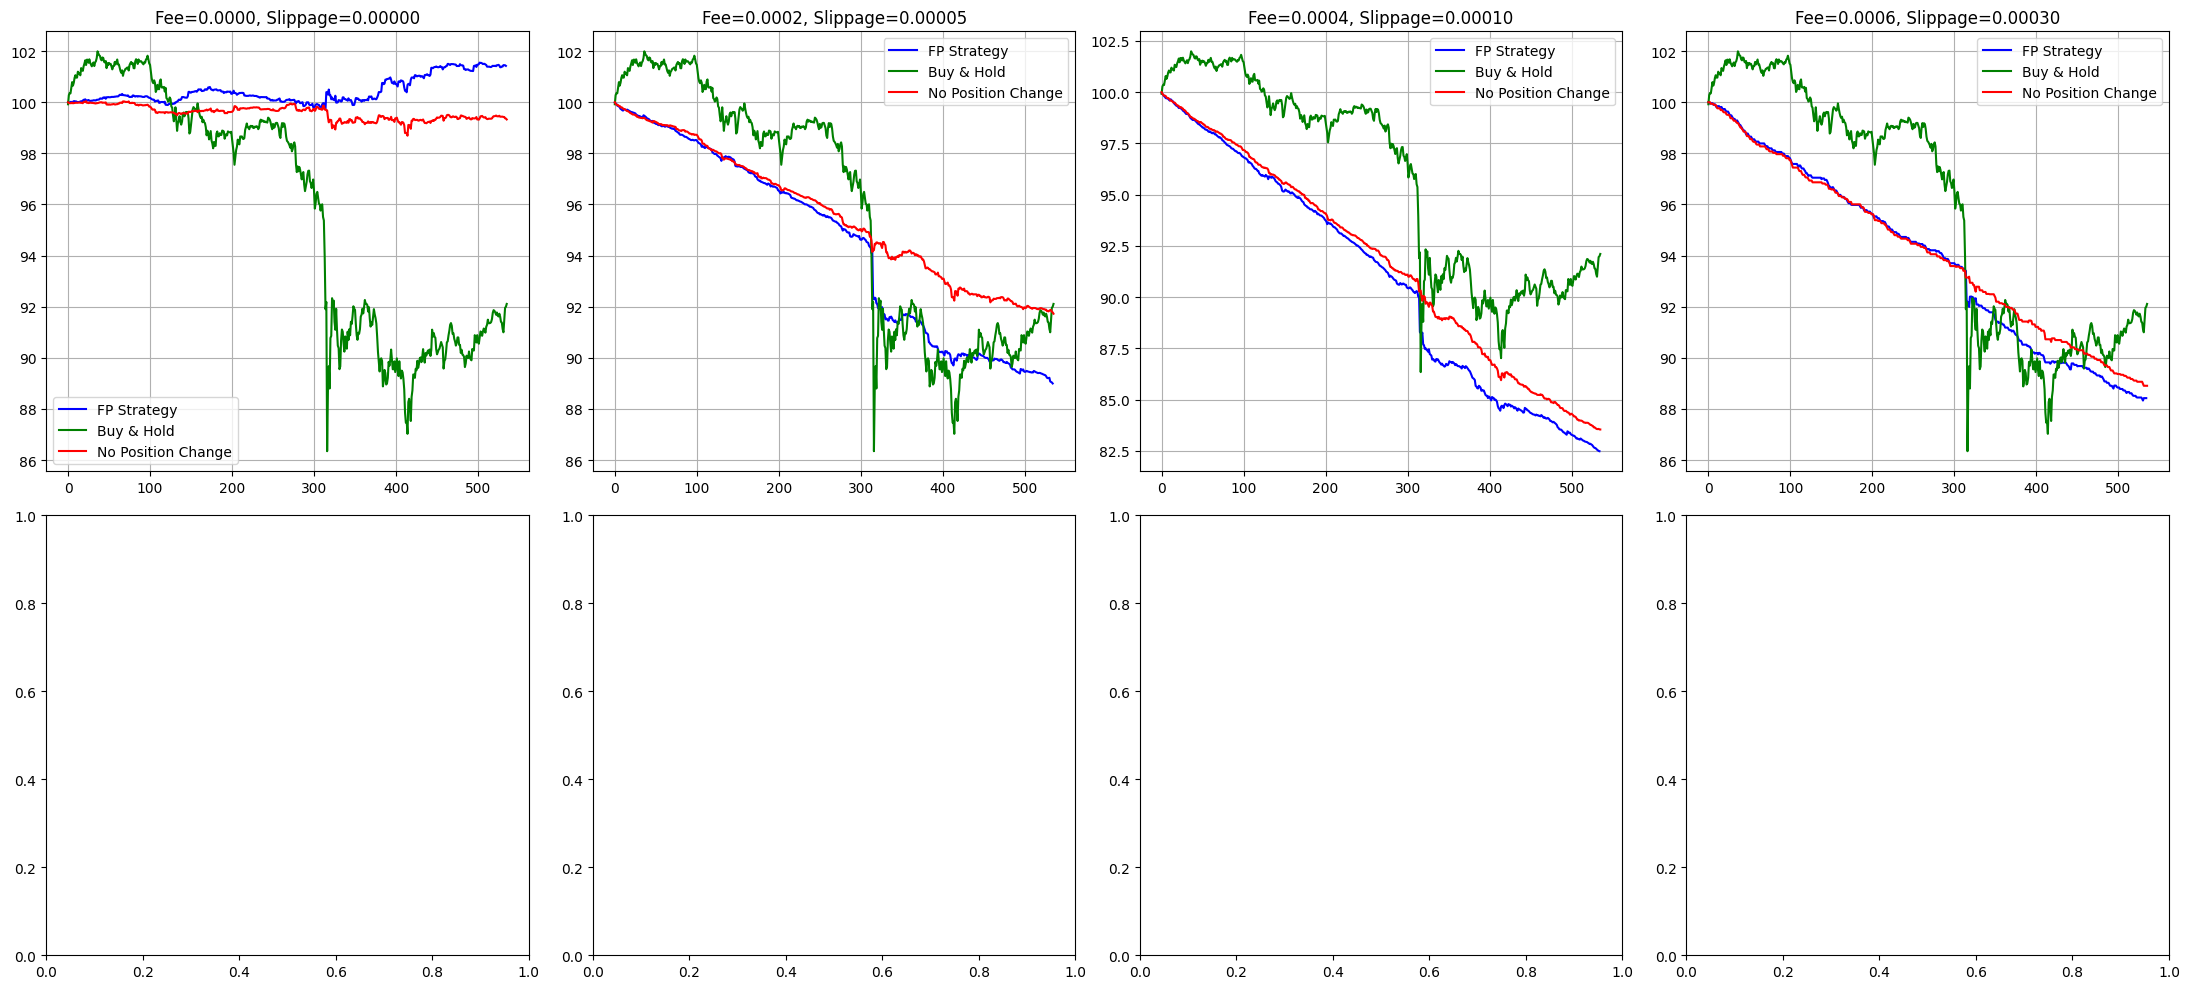


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000           101.42           1.42           92.11                  -7.89    99.33           -0.67
0.0002   0.00005            89.00         -11.00           92.11                  -7.89    91.73           -8.27
0.0004   0.00010            82.49         -17.51           92.11                  -7.89    83.55          -16.45
0.0006   0.00030            88.42         -11.58           92.11                  -7.89    88.91          -11.09


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt
from numba import njit
from sklearn.preprocessing import RobustScaler
from scipy.stats import norm
from statsmodels.tsa.statespace.tools import constrain_stationary_univariate

np.random.seed(42)
random_seed = 42

df = pd.read_csv("BTC_5min.csv", parse_dates=['system_time'], index_col='system_time')
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}'] * (1 + 0.1 * np.random.randn(len(df)))
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}'] * (1 + 0.1 * np.random.randn(len(df)))

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = np.log1p(df[bid_cols + ask_cols].sum(axis=1))
df['queue_slope'] = (df['bids_notional_0'] - df['bids_notional_5']) / (df['bids_notional_0'] + 1e-8)

scaler = RobustScaler()
features = ['obi', 'dobi', 'depth', 'queue_slope']
df[features] = scaler.fit_transform(df[features])

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

df_train['log_mid'] = np.log(df_train['midpoint'])
df_train['returns'] = df_train['log_mid'].diff().fillna(0)
df_cv['log_mid'] = np.log(df_cv['midpoint'])
df_cv['returns'] = df_cv['log_mid'].diff().fillna(0)
df_test['log_mid'] = np.log(df_test['midpoint'])
df_test['returns'] = df_test['log_mid'].diff().fillna(0)

@njit
def trading_strategy(signal, threshold, volatility):
    positions = np.zeros(len(signal))
    for i in range(1, len(signal)):
        z_score = signal[i] / (volatility[i] + 1e-8)
        if z_score > threshold:
            positions[i] = min(positions[i-1] + 0.1, 1)
        elif z_score < -threshold:
            positions[i] = max(positions[i-1] - 0.1, -1)
        else:
            positions[i] = positions[i-1] * 0.95
    # Manual diff with prepend=0
    trades = np.zeros(len(positions))
    trades[0] = positions[0]
    for i in range(1, len(positions)):
        trades[i] = positions[i] - positions[i-1]
    return positions, trades

@njit
def apply_trading_costs(positions, trades, returns, fee, slip, volatility):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip * volatility[1:len(positions)][trade_mask]
    net_pnl = raw_pnl - costs
    return net_pnl

@njit
def simulate_fp(mu_params, sigma_params, x0, obi, timesteps, dt):
    a0, a1, a2, a3 = mu_params
    b0, b1, b2 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    for t in range(1, timesteps):
        mu = a0 + a1 * x[t-1] + a2 * obi[t-1] + a3 * np.tanh(x[t-1])
        sigma = np.exp(b0 + b1 * np.log1p(np.abs(x[t-1])) + b2)
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * np.random.randn()
    return x

def optimize_threshold(signal, returns, fee, slip, volatility):
    thresholds = np.geomspace(0.001, 0.1, 20)
    best_pnl = -np.inf
    best_thresh = 0.01
    for t in thresholds:
        pos, trades = trading_strategy(signal, t, volatility)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip, volatility))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    obi = df_slice['obi'].values
    x_init = 0.0
    dt = 1.0

    def objective(params):
        mu_params = params[:4]
        sigma_params = params[4:]
        signal = simulate_fp(mu_params, sigma_params, x_init, obi, len(returns), dt)
        volatility = np.sqrt(np.mean(np.diff(signal)**2))
        pos, trades = trading_strategy(signal, 0.01, np.ones_like(signal)*volatility)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip, np.ones_like(signal)*volatility))

    res = fmin(objective, [0, -0.5, 0.5, 0.1, -2, 0.1, 0.01], sigma0=0.2, options={'seed':random_seed, 'popsize':20})
    return res[0][:4], res[0][4:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i*200, (i+1)*200) for i in range(5)]
    segment_models = []
    segment_thresholds = []

    for start, end in train_segments:
        if end > len(df_train):
            continue
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end]['obi'].values, end-start, 1.0)
        volatility = np.sqrt(np.mean(np.diff(signal)**2))
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip, np.ones_like(signal)*volatility)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 5
    cv_returns = df_cv['returns'].values
    cv_obi = df_cv['obi'].values
    selected_model_indices = []

    for start in range(0, len(cv_returns) - window_size + 1, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, cv_obi[start:end], window_size, 1.0)
            volatility = np.sqrt(np.mean(np.diff(signal)**2))
            pos, trades = trading_strategy(signal, segment_thresholds[i], np.ones_like(signal)*volatility)
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip, np.ones_like(signal)*volatility))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_obi = df_test['obi'].values
    test_positions = []
    test_trades = []
    test_volatility = []

    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_obi[start:end], window_size, 1.0)
        volatility = np.sqrt(np.mean(np.diff(signal)**2))
        pos, trades = trading_strategy(signal, threshold, np.ones_like(signal)*volatility)
        test_positions.append(pos)
        test_trades.append(trades)
        test_volatility.extend([volatility]*len(pos))

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_volatility = np.array(test_volatility[:len(fp_positions)])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns), len(fp_volatility))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_volatility = fp_volatility[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip, fp_volatility)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    npc_returns = fp_positions * bh_returns - (fee + slip * fp_volatility) * (np.abs(fp_trades) > 0)
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee:.4f}, Slippage={slip:.5f}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))

(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 7 (seed=42, Tue Jul 22 17:29:11 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     25 -6.218165185803152e-03 1.0e+00 1.57e-01  1e-01  2e-01 0:01.3
    2     50 -3.756141581336973e-03 1.3e+00 1.59e-01  1e-01  2e-01 0:01.3
    3     75 -1.510502296541780e-02 1.5e+00 1.61e-01  1e-01  2e-01 0:01.3


/tmp/ipython-input-3-1096312254.py:108: RuntimeWarning: overflow encountered in square
  volatility = np.sqrt(np.mean(np.diff(signal)**2))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


  100   2500 -2.958879900155347e-02 5.2e+01 1.65e-01  2e-02  2e-01 0:01.7
  150   3750 -3.064222685493495e-02 1.1e+02 4.82e-02  3e-03  3e-02 0:02.0
termination on maxiter=150 (Tue Jul 22 17:29:14 2025)
final/bestever f-value = -2.234882e-02 -3.536534e-02 after 3751/186 evaluations
incumbent solution: [-0.20356515, -0.27016074, -2.91851938, 1.03296212, -2.64390289, 0.27879838, 1.75327956]
std deviation: [0.00272984, 0.0048344, 0.03026478, 0.01626592, 0.02263051, 0.02948489, 0.02101151]
(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 7 (seed=42, Tue Jul 22 17:29:14 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     25 -1.651478708301495e-02 1.0e+00 1.61e-01  2e-01  2e-01 0:00.0
    2     50 -1.176861108684326e-02 1.4e+00 1.64e-01  1e-01  2e-01 0:00.0
    3     75 -1.225114237091240e-02 1.5e+00 1.60e-01  1e-01  2e-01 0:00.0
  100   2500 -1.318131665502729e-02 1.8e+01 1.70e-01  5e-02  1e-01 0:00.5
  150   3750 -1.284766160891513e-02 6.7e+01 1.93e-01  

/tmp/ipython-input-3-1096312254.py:108: RuntimeWarning: overflow encountered in square
  volatility = np.sqrt(np.mean(np.diff(signal)**2))


  150   3750 -9.378598406765979e-03 6.6e+02 1.57e-01  9e-08  5e-01 0:00.9
termination on maxiter=150 (Tue Jul 22 17:29:23 2025)
final/bestever f-value = -9.378598e-03 -9.378598e-03 after 3751/3651 evaluations
incumbent solution: [ 6.93367618e-07, -9.38710459e-01, 5.55783365e-09, 1.97381094e+00, -1.22114923e+01, 6.85207816e+00, -5.49593341e+00]
std deviation: [6.12891058e-07, 5.98095154e-02, 9.26199195e-08, 1.86132695e-01, 4.81062255e-01, 3.73735861e-01, 3.06505660e-01]
(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 7 (seed=42, Tue Jul 22 17:29:23 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     25 -7.011612237721095e-03 1.0e+00 1.68e-01  1e-01  2e-01 0:00.0
    2     50 -7.518549286287819e-03 1.5e+00 2.13e-01  2e-01  3e-01 0:00.0
    3     75 -7.550527561762524e-03 1.6e+00 2.50e-01  2e-01  3e-01 0:00.0
NOTE (module=cma, iteration=86):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 1.4e+08 to 2.4e

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


NOTE (module=cma, iteration=90):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 1.2e+08 to 4.3e+01
  100   2500 -5.465178702073414e-03 1.1e+01 1.34e-01  1e-05  6e-01 0:00.4
  150   3750 -5.465183068844795e-03 1.4e+03 5.89e-02  3e-08  3e-01 0:00.7
termination on maxiter=150 (Tue Jul 22 17:29:25 2025)
final/bestever f-value = -5.465183e-03 -5.497239e-03 after 3751/200 evaluations
incumbent solution: [ 2.76371447e-07, -1.34907459e+00, -7.73413495e-09, 2.56178250e+00, -9.73920655e+00, -4.94842554e+00, -9.10426366e+00]
std deviation: [2.44308498e-07, 5.22513104e-02, 3.24734489e-08, 8.07831253e-02, 1.56025005e-01, 2.20507358e-01, 3.19791295e-01]
(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 7 (seed=42, Tue Jul 22 17:29:25 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     25 -4.692297712348501e-05 1.0e+00 1.79e-01  2e-01  2e-01 0:00.0
    2     50 -2.074957504047670e-03 1.4e+00 2.12e-01  2e-01  3e-01 0:

/tmp/ipython-input-3-1096312254.py:134: RuntimeWarning: overflow encountered in square
  volatility = np.sqrt(np.mean(np.diff(signal)**2))


NOTE (module=cma, iteration=87):  
condition in coordinate system exceeded 1.4e+08, rescaled to 1.0e+00, 
condition changed from 1.8e+08 to 8.3e+01
  100   2500 -3.465172219152100e-03 7.6e+00 2.53e-01  1e-05  7e-01 0:00.4
  150   3750 -3.465183049279102e-03 1.4e+03 8.06e-02  4e-08  3e-01 0:00.7
termination on maxiter=150 (Tue Jul 22 17:29:30 2025)
final/bestever f-value = -3.465183e-03 -3.465183e-03 after 3751/3738 evaluations
incumbent solution: [ 3.25853562e-07, -4.75591524e+00, -3.24496297e-09, 1.00109284e+01, -4.30836859e+00, -5.04512326e+00, -1.41296678e+01]
std deviation: [3.09338147e-07, 8.65557339e-02, 3.59806545e-08, 2.15308712e-01, 1.89696347e-01, 1.55526627e-01, 2.75522525e-01]
(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 7 (seed=42, Tue Jul 22 17:29:30 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     25 2.762596062547140e-04 1.0e+00 1.71e-01  2e-01  2e-01 0:00.0
    2     50 1.663448048295785e-04 1.5e+00 1.86e-01  2e-01  2e-01 0:0

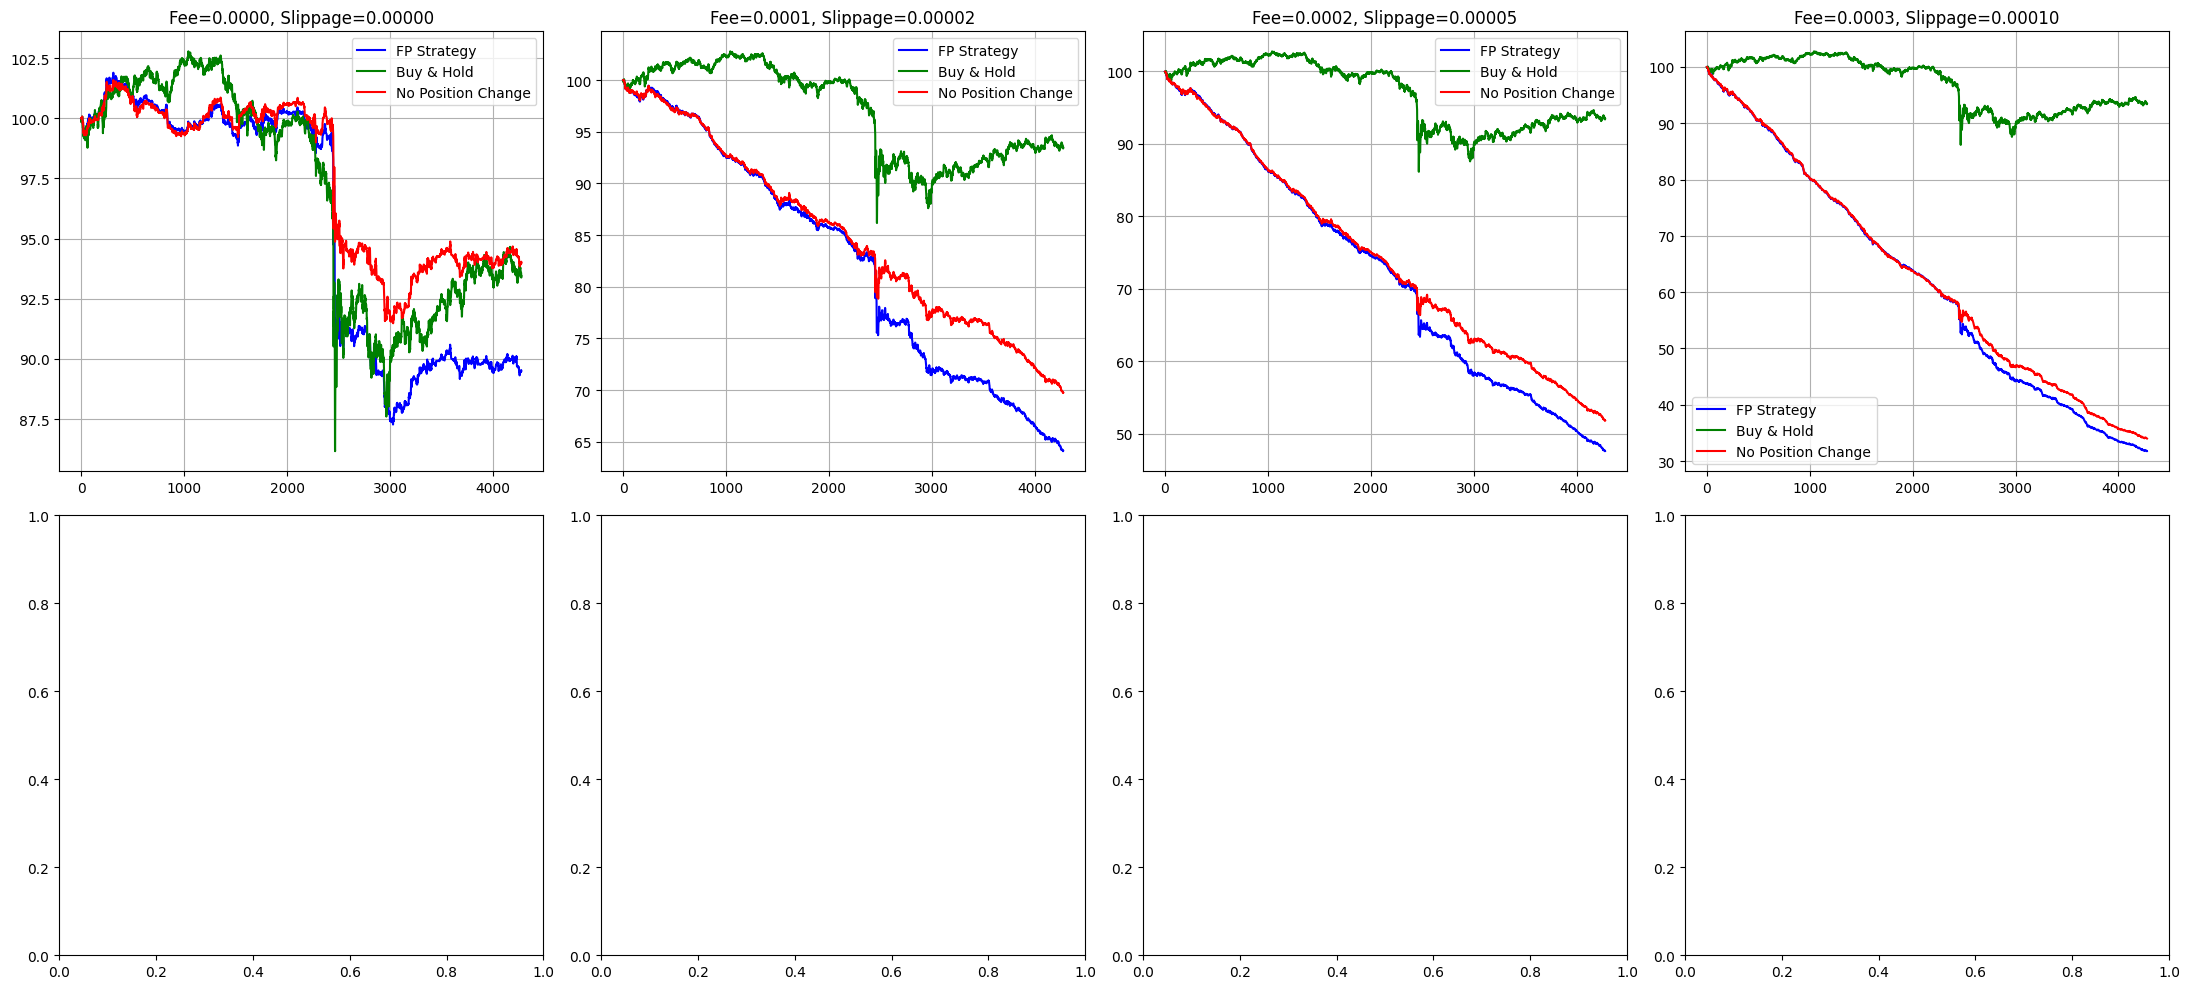


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            89.51         -10.49           93.45                  -6.55    94.01           -5.99
0.0001   0.00002            64.12         -35.88           93.45                  -6.55    69.75          -30.25
0.0002   0.00005            47.64         -52.36           93.45                  -6.55    51.84          -48.16
0.0003   0.00010            31.76         -68.24           93.45                  -6.55    34.00          -66.00


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt
from numba import njit
from sklearn.preprocessing import RobustScaler

np.random.seed(42)
random_seed = 42

# Load 1-minute data
df = pd.read_csv("BTC_1min.csv", parse_dates=['system_time'], index_col='system_time')

# Feature engineering with noise reduction
for j in range(15):
    noise_factor = 0.05  # Reduced noise for 1min data
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}'] * (1 + noise_factor * np.random.randn(len(df)))
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}'] * (1 + noise_factor * np.random.randn(len(df)))

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]

# Enhanced OBI calculation with smoothing
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().rolling(5, min_periods=1).mean().fillna(0)  # 5-min smoothing
df['depth'] = np.log1p(df[bid_cols + ask_cols].sum(axis=1))
df['queue_slope'] = (df['bids_notional_0'] - df['bids_notional_5']) / (df['bids_notional_0'] + 1e-8)

# Feature scaling
scaler = RobustScaler()
features = ['obi', 'dobi', 'depth', 'queue_slope']
df[features] = scaler.fit_transform(df[features])

# Adjusted time splits for 1min data (more recent test set)
train_end = int(len(df) * 0.5)  # 50% training
cv_end = int(len(df) * 0.75)    # 25% validation
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

# Returns calculation
for df_part in [df_train, df_cv, df_test]:
    df_part['log_mid'] = np.log(df_part['midpoint'])
    df_part['returns'] = df_part['log_mid'].diff().fillna(0)

# Trading strategy with position smoothing
@njit
def trading_strategy(signal, threshold, volatility):
    positions = np.zeros(len(signal))
    for i in range(1, len(signal)):
        z_score = signal[i] / (volatility[i] + 1e-8)
        if z_score > threshold:
            positions[i] = min(positions[i-1] + 0.05, 1)  # Slower position buildup
        elif z_score < -threshold:
            positions[i] = max(positions[i-1] - 0.05, -1)
        else:
            positions[i] = positions[i-1] * 0.98  # Slower decay
    # Manual diff calculation
    trades = np.zeros(len(positions))
    trades[0] = positions[0]
    for i in range(1, len(positions)):
        trades[i] = positions[i] - positions[i-1]
    return positions, trades

@njit
def apply_trading_costs(positions, trades, returns, fee, slip, volatility):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip * volatility[1:len(positions)][trade_mask]
    net_pnl = raw_pnl - costs
    return net_pnl

@njit
def simulate_fp(mu_params, sigma_params, x0, obi, timesteps, dt):
    a0, a1, a2, a3 = mu_params
    b0, b1, b2 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    for t in range(1, timesteps):
        mu = a0 + a1 * x[t-1] + a2 * obi[t-1] + a3 * np.tanh(x[t-1]/3.0)  # Smoother transition
        sigma = np.exp(b0 + b1 * np.log1p(np.abs(x[t-1])/10.0) + b2)  # More stable volatility
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * np.random.randn()
    return x

def optimize_threshold(signal, returns, fee, slip, volatility):
    thresholds = np.geomspace(0.0005, 0.05, 25)  # Wider range for 1min
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t, volatility)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip, volatility))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    obi = df_slice['obi'].values
    x_init = 0.0
    dt = 1.0

    def objective(params):
        mu_params = params[:4]
        sigma_params = params[4:]
        signal = simulate_fp(mu_params, sigma_params, x_init, obi, len(returns), dt)
        volatility = np.sqrt(np.mean(np.diff(signal)**2))
        pos, trades = trading_strategy(signal, 0.005, np.ones_like(signal)*volatility)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip, np.ones_like(signal)*volatility))

    res = fmin(objective, [0, -0.3, 0.3, 0.05, -1.5, 0.05, 0.005],
               sigma0=0.15, options={'seed':random_seed, 'popsize':25, 'maxiter':150})
    return res[0][:4], res[0][4:]

# Adjusted fee structure for 1min trading
fees = [0, 0.0001, 0.0002, 0.0003]
slippages = [0, 0.00002, 0.00005, 0.0001]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    # Adjusted training segments for 1min (smaller windows)
    train_segments = [(i*500, (i+1)*500) for i in range(6)]  # 500-min (8.3hr) segments
    segment_models = []
    segment_thresholds = []

    for start, end in train_segments:
        if end > len(df_train):
            continue
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end]['obi'].values, end-start, 1.0)
        volatility = np.sqrt(np.mean(np.diff(signal)**2))
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip, np.ones_like(signal)*volatility)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    # Adjusted window size for 1min (30-min windows)
    window_size = 30
    cv_returns = df_cv['returns'].values
    cv_obi = df_cv['obi'].values
    selected_model_indices = []

    for start in range(0, len(cv_returns) - window_size + 1, window_size//2):  # 50% overlap
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, cv_obi[start:end], window_size, 1.0)
            volatility = np.sqrt(np.mean(np.diff(signal)**2))
            pos, trades = trading_strategy(signal, segment_thresholds[i], np.ones_like(signal)*volatility)
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip, np.ones_like(signal)*volatility))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_obi = df_test['obi'].values
    test_positions = []
    test_trades = []
    test_volatility = []

    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size//2)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_obi[start:end], window_size, 1.0)
        volatility = np.sqrt(np.mean(np.diff(signal)**2))
        pos, trades = trading_strategy(signal, threshold, np.ones_like(signal)*volatility)
        test_positions.append(pos)
        test_trades.append(trades)
        test_volatility.extend([volatility]*len(pos))

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_volatility = np.array(test_volatility[:len(fp_positions)])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns), len(fp_volatility))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_volatility = fp_volatility[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip, fp_volatility)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    npc_returns = fp_positions * bh_returns - (fee + slip * fp_volatility) * (np.abs(fp_trades) > 0)
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee:.4f}, Slippage={slip:.5f}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))

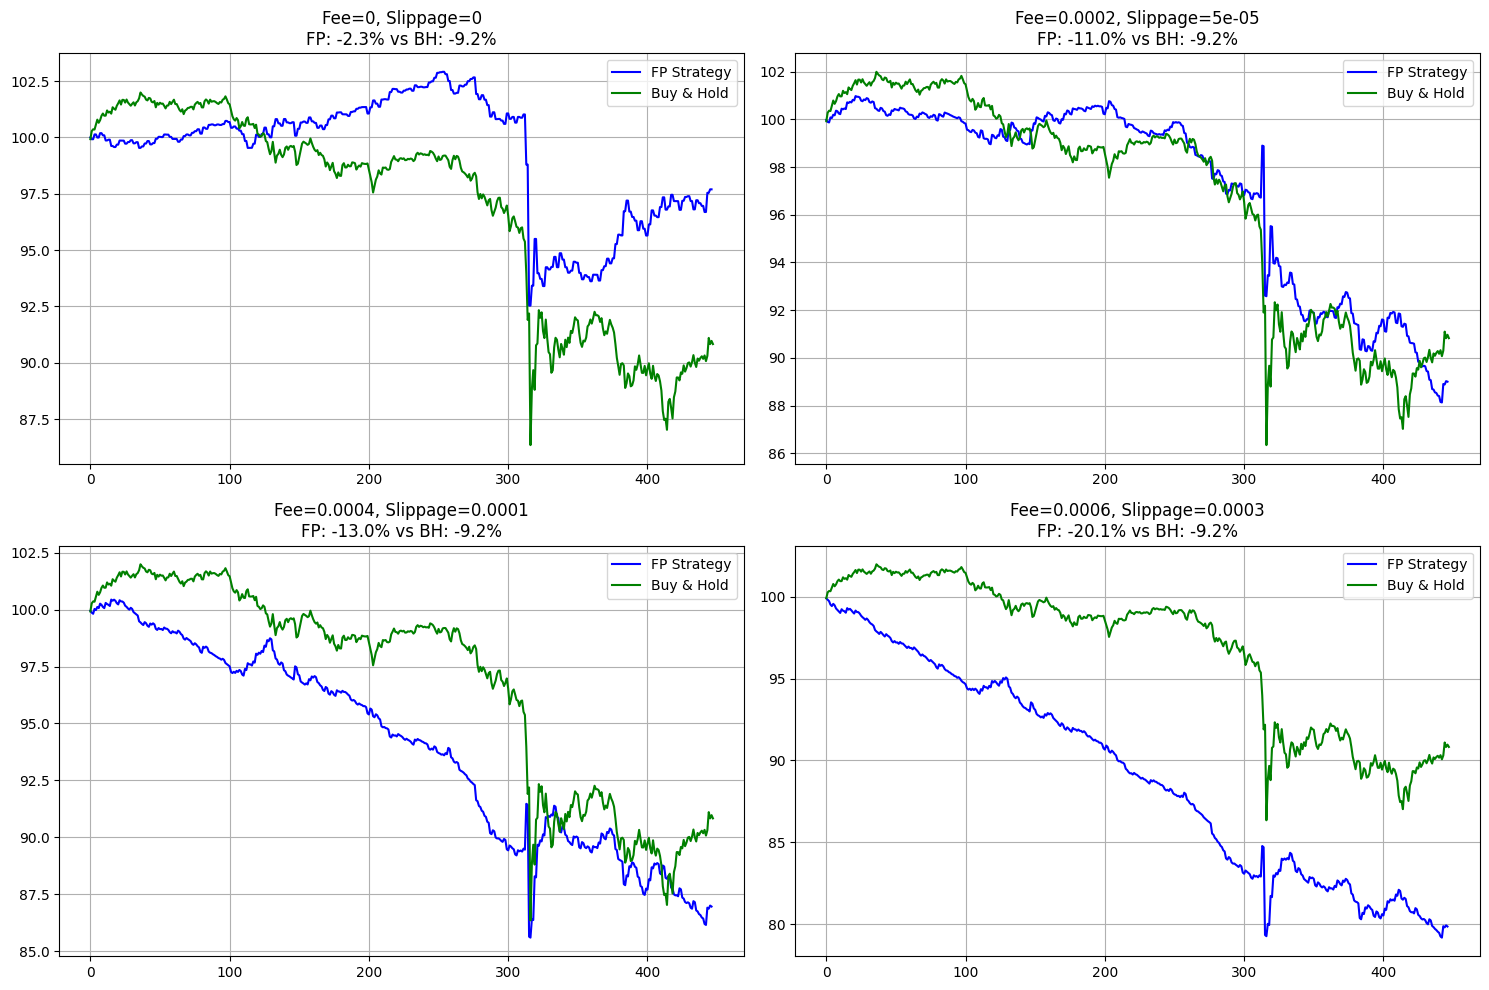


Performance Metrics Across Different Cost Scenarios:
 Fee  Slippage  FP Return (%)  FP Sharpe  FP Drawdown (%)  BH Return (%)  BH Sharpe  BH Drawdown (%)
0.00      0.00          -2.31      -4.22            -7.46          -9.17     -14.53           -13.65
0.00      0.00         -11.00     -21.12           -11.87          -9.17     -14.53           -13.65
0.00      0.00         -13.05     -25.29           -14.41          -9.17     -14.53           -13.65
0.00      0.00         -20.15     -40.55           -20.83          -9.17     -14.53           -13.65


In [ ]:
import pandas as pd
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

# Configuration
class Config:
    RANDOM_SEED = 42
    TRAIN_RATIO = 0.6
    CV_RATIO = 0.2
    TEST_RATIO = 0.2
    INITIAL_CAPITAL = 100
    FEE_SLIPPAGE_COMBOS = [
        (0, 0),
        (0.0002, 0.00005),
        (0.0004, 0.0001),
        (0.0006, 0.0003)
    ]
    WINDOW_SIZE = 3
    N_MODEL_SEGMENTS = 5

np.random.seed(Config.RANDOM_SEED)

# Data Preparation
def prepare_data(filepath: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load and preprocess the data"""
    df = pd.read_csv(filepath)

    # Calculate price levels
    for j in range(15):
        df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
        df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

    # Calculate features
    bid_cols = [f"bids_notional_{i}" for i in range(15)]
    ask_cols = [f"asks_notional_{i}" for i in range(15)]

    df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (
        df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
    df['dobi'] = df['obi'].diff().fillna(0)
    df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
    df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']
    df['spread'] = df['ask_price_0'] - df['bid_price_0']

    # Log returns
    df['log_mid'] = np.log(df['midpoint'])
    df['returns'] = df['log_mid'].diff().fillna(0)

    # Train/Validation/Test split
    train_end = int(len(df) * Config.TRAIN_RATIO)
    cv_end = int(len(df) * (Config.TRAIN_RATIO + Config.CV_RATIO))

    df_train = df.iloc[:train_end].copy().reset_index(drop=True)
    df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
    df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

    # Feature scaling
    scaler = StandardScaler()
    scale_cols = ['obi', 'depth', 'queue_slope', 'spread']
    df_train[scale_cols] = scaler.fit_transform(df_train[scale_cols])
    df_cv[scale_cols] = scaler.transform(df_cv[scale_cols])
    df_test[scale_cols] = scaler.transform(df_test[scale_cols])

    return df_train, df_cv, df_test

# Trading Strategy Components
def trading_strategy(signal: np.ndarray, threshold: float) -> Tuple[np.ndarray, np.ndarray]:
    """Generate positions from trading signals"""
    positions = np.zeros_like(signal)
    positions[signal > threshold] = 1
    positions[signal < -threshold] = -1
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(
    positions: np.ndarray,
    trades: np.ndarray,
    returns: np.ndarray,
    fee: float,
    slip: float,
    trade_sizes: np.ndarray = None
) -> np.ndarray:
    """Calculate PnL with realistic trading costs"""
    raw_pnl = positions[:-1] * returns[1:len(positions)]

    # Dynamic slippage based on trade size and liquidity
    if trade_sizes is None:
        costs = np.abs(trades[1:len(positions)]) * (fee + slip)
    else:
        liquidity_impact = 0.0001 * (trade_sizes / 1e6)  # Assume liquidity in millions
        costs = np.abs(trades[1:len(positions)]) * (fee + slip + liquidity_impact)

    return raw_pnl - costs

# Signal Generation Model
def simulate_fp(
    mu_params: List[float],
    sigma_params: List[float],
    x0: float,
    obi: np.ndarray,
    timesteps: int,
    dt: float = 1.0
) -> np.ndarray:
    """Fokker-Planck inspired signal generation"""
    a0, a1, a2 = mu_params
    b0, b1 = sigma_params

    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(Config.RANDOM_SEED)

    for t in range(1, timesteps):
        mu = a0 + a1 * x[t-1] + a2 * obi[t-1]
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()

    return x

# Optimization
def optimize_threshold(
    signal: np.ndarray,
    returns: np.ndarray,
    fee: float,
    slip: float
) -> float:
    """Find optimal trading threshold"""
    thresholds = np.linspace(0.001, 0.01, 20)
    best_pnl = -np.inf
    best_thresh = 0.005

    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))

        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t

    return best_thresh

def train_fp_model(
    df_slice: pd.DataFrame,
    fee: float,
    slip: float
) -> Tuple[List[float], List[float]]:
    """Train model using Bayesian optimization"""
    returns = df_slice['returns'].values
    obi = df_slice['obi'].values
    x_init = 0.0

    def objective(params):
        mu_params = params[:3]
        sigma_params = params[3:]
        signal = simulate_fp(mu_params, sigma_params, x_init, obi, len(returns))
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))

    space = [
        Real(-1, 1, name='a0'),
        Real(-1, 1, name='a1'),
        Real(-1, 1, name='a2'),
        Real(0.0001, 0.1, name='b0'),
        Real(0.0001, 0.1, name='b1')
    ]

    res = gp_minimize(objective, space, n_calls=50, random_state=Config.RANDOM_SEED)
    return res.x[:3], res.x[3:]

# Backtest Framework
def run_backtest(
    df_train: pd.DataFrame,
    df_cv: pd.DataFrame,
    df_test: pd.DataFrame,
    fee: float,
    slip: float
) -> Dict:
    """Complete backtest pipeline for one fee/slippage combo"""
    # 1. Train multiple models on different segments
    segment_size = len(df_train) // Config.N_MODEL_SEGMENTS
    segment_models = []
    segment_thresholds = []

    for i in range(Config.N_MODEL_SEGMENTS):
        start = i * segment_size
        end = (i + 1) * segment_size
        if end > len(df_train):
            continue

        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0,
                           df_train.iloc[start:end]['obi'].values,
                           end - start)
        threshold = optimize_threshold(signal,
                                     df_train.iloc[start:end]['returns'].values,
                                     fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    # 2. Model selection on CV data
    selected_models = []
    cv_returns = df_cv['returns'].values
    cv_obi = df_cv['obi'].values

    for start in range(0, len(cv_returns) - Config.WINDOW_SIZE, Config.WINDOW_SIZE):
        end = start + Config.WINDOW_SIZE
        best_pnl = -np.inf
        best_index = 0

        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0,
                               cv_obi[start:end],
                               Config.WINDOW_SIZE)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades,
                                            cv_returns[start:end],
                                            fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i

        selected_models.append(best_index)

    # 3. Test on out-of-sample data
    test_returns = df_test['returns'].values
    test_obi = df_test['obi'].values
    test_positions = []
    test_trades = []

    for i, start in enumerate(range(0, len(test_returns) - Config.WINDOW_SIZE + 1, Config.WINDOW_SIZE)):
        end = start + Config.WINDOW_SIZE
        model_idx = selected_models[min(i, len(selected_models) - 1)]
        mu_p, sigma_p = segment_models[model_idx]
        threshold = segment_thresholds[model_idx]

        signal = simulate_fp(mu_p, sigma_p, 0.0,
                           test_obi[start:end],
                           min(Config.WINDOW_SIZE, len(test_returns) - start))
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    # Combine results
    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    # Calculate PnLs
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = Config.INITIAL_CAPITAL * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = Config.INITIAL_CAPITAL * np.exp(np.cumsum(bh_returns))

    # Calculate metrics
    def calculate_metrics(returns):
        total_return = (np.exp(np.sum(returns)) - 1) * 100
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(365*24*12)  # 5min periods
        max_drawdown = (np.exp(np.min(returns.cumsum())) - 1) * 100
        return total_return, sharpe, max_drawdown

    fp_metrics = calculate_metrics(fp_net_returns)
    bh_metrics = calculate_metrics(bh_returns)

    return {
        'fee': fee,
        'slippage': slip,
        'fp_pnl': fp_pnl,
        'bh_pnl': bh_pnl,
        'fp_return_pct': fp_metrics[0],
        'fp_sharpe': fp_metrics[1],
        'fp_drawdown_pct': fp_metrics[2],
        'bh_return_pct': bh_metrics[0],
        'bh_sharpe': bh_metrics[1],
        'bh_drawdown_pct': bh_metrics[2]
    }

# Main Execution
if __name__ == "__main__":
    # Load and prepare data
    df_train, df_cv, df_test = prepare_data("BTC_5min.csv")

    # Run backtests for all fee/slippage combinations
    results = []
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (fee, slip) in enumerate(Config.FEE_SLIPPAGE_COMBOS):
        result = run_backtest(df_train, df_cv, df_test, fee, slip)
        results.append(result)

        # Plotting
        ax = axes[idx]
        ax.plot(result['fp_pnl'], label='FP Strategy', color='blue')
        ax.plot(result['bh_pnl'], label='Buy & Hold', color='green')
        ax.set_title(f"Fee={fee}, Slippage={slip}\n"
                    f"FP: {result['fp_return_pct']:.1f}% vs BH: {result['bh_return_pct']:.1f}%")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Results table
    results_df = pd.DataFrame([{
        'Fee': r['fee'],
        'Slippage': r['slippage'],
        'FP Return (%)': r['fp_return_pct'],
        'FP Sharpe': r['fp_sharpe'],
        'FP Drawdown (%)': r['fp_drawdown_pct'],
        'BH Return (%)': r['bh_return_pct'],
        'BH Sharpe': r['bh_sharpe'],
        'BH Drawdown (%)': r['bh_drawdown_pct']
    } for r in results])

    print("\nPerformance Metrics Across Different Cost Scenarios:")
    print(results_df.to_string(index=False, float_format="%.2f"))

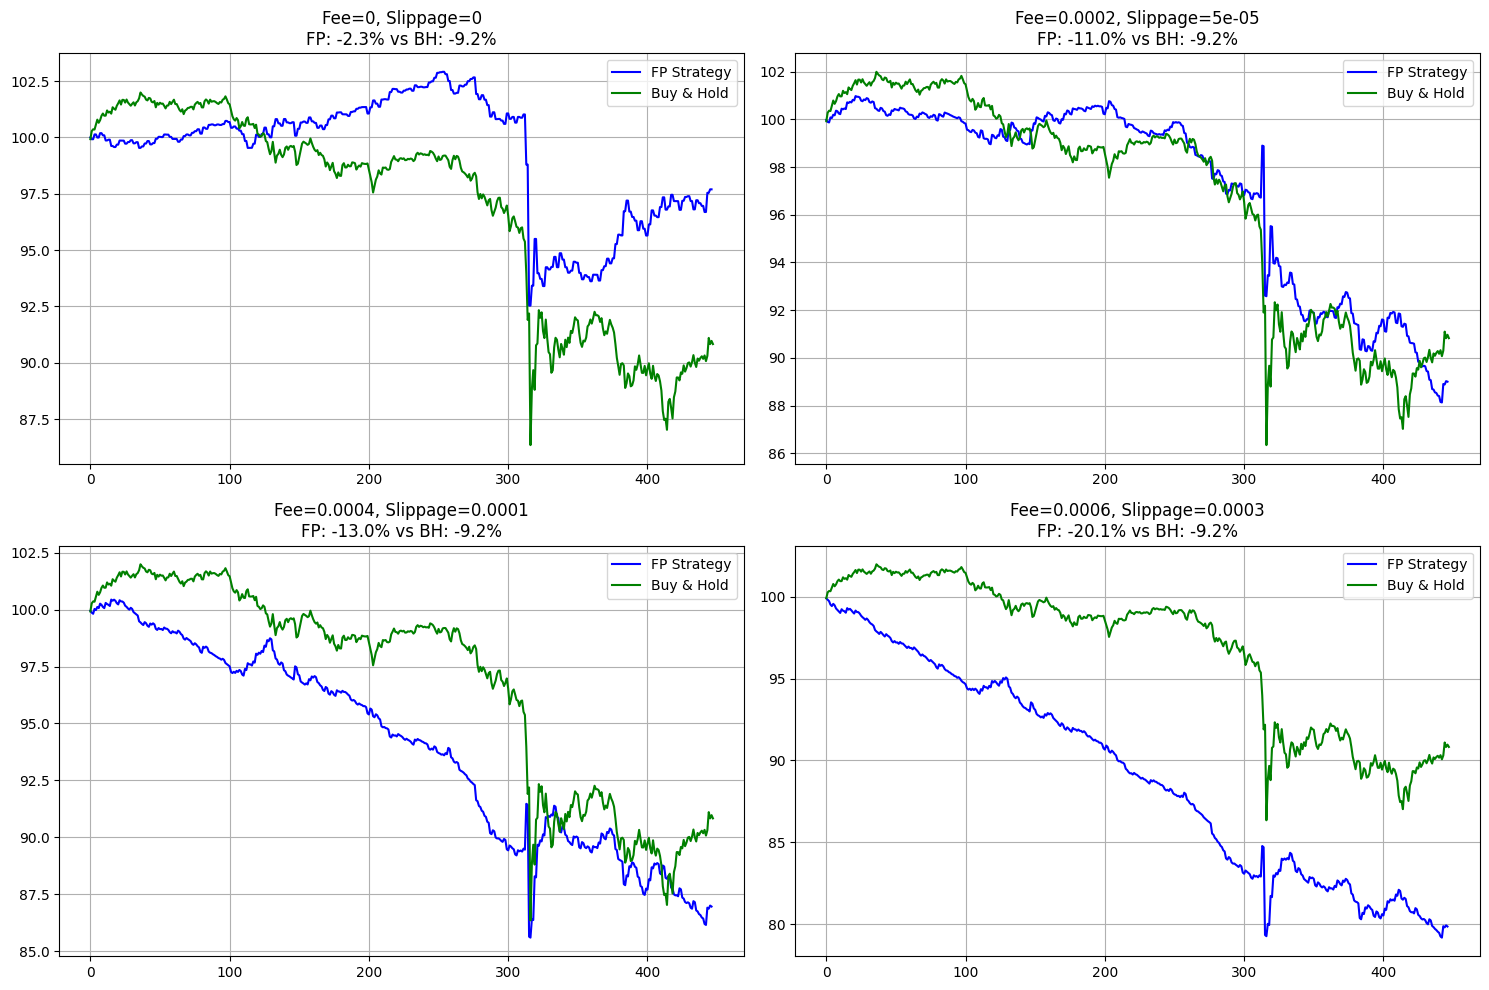


Performance Metrics Across Different Cost Scenarios:
 Fee  Slippage  FP Return (%)  FP Sharpe  FP Drawdown (%)  BH Return (%)  BH Sharpe  BH Drawdown (%)
0.00      0.00          -2.31      -4.22            -7.46          -9.17     -14.53           -13.65
0.00      0.00         -11.00     -21.12           -11.87          -9.17     -14.53           -13.65
0.00      0.00         -13.05     -25.29           -14.41          -9.17     -14.53           -13.65
0.00      0.00         -20.15     -40.55           -20.83          -9.17     -14.53           -13.65


In [ ]:
import pandas as pd
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

# Configuration
class Config:
    RANDOM_SEED = 42
    TRAIN_RATIO = 0.6
    CV_RATIO = 0.2
    TEST_RATIO = 0.2
    INITIAL_CAPITAL = 100
    FEE_SLIPPAGE_COMBOS = [
        (0, 0),
        (0.0002, 0.00005),
        (0.0004, 0.0001),
        (0.0006, 0.0003)
    ]
    WINDOW_SIZE = 3
    N_MODEL_SEGMENTS = 5

np.random.seed(Config.RANDOM_SEED)

# Data Preparation
def prepare_data(filepath: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load and preprocess the data"""
    df = pd.read_csv(filepath)

    # Calculate price levels
    for j in range(15):
        df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
        df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

    # Calculate features
    bid_cols = [f"bids_notional_{i}" for i in range(15)]
    ask_cols = [f"asks_notional_{i}" for i in range(15)]

    df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (
        df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
    df['dobi'] = df['obi'].diff().fillna(0)
    df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
    df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']
    df['spread'] = df['ask_price_0'] - df['bid_price_0']

    # Log returns
    df['log_mid'] = np.log(df['midpoint'])
    df['returns'] = df['log_mid'].diff().fillna(0)

    # Train/Validation/Test split
    train_end = int(len(df) * Config.TRAIN_RATIO)
    cv_end = int(len(df) * (Config.TRAIN_RATIO + Config.CV_RATIO))

    df_train = df.iloc[:train_end].copy().reset_index(drop=True)
    df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
    df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

    # Feature scaling
    scaler = StandardScaler()
    scale_cols = ['obi', 'depth', 'queue_slope', 'spread']
    df_train[scale_cols] = scaler.fit_transform(df_train[scale_cols])
    df_cv[scale_cols] = scaler.transform(df_cv[scale_cols])
    df_test[scale_cols] = scaler.transform(df_test[scale_cols])

    return df_train, df_cv, df_test

# Trading Strategy Components
def trading_strategy(signal: np.ndarray, threshold: float) -> Tuple[np.ndarray, np.ndarray]:
    """Generate positions from trading signals"""
    positions = np.zeros_like(signal)
    positions[signal > threshold] = 1
    positions[signal < -threshold] = -1
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(
    positions: np.ndarray,
    trades: np.ndarray,
    returns: np.ndarray,
    fee: float,
    slip: float,
    trade_sizes: np.ndarray = None
) -> np.ndarray:
    """Calculate PnL with realistic trading costs"""
    raw_pnl = positions[:-1] * returns[1:len(positions)]

    # Dynamic slippage based on trade size and liquidity
    if trade_sizes is None:
        costs = np.abs(trades[1:len(positions)]) * (fee + slip)
    else:
        liquidity_impact = 0.0001 * (trade_sizes / 1e6)  # Assume liquidity in millions
        costs = np.abs(trades[1:len(positions)]) * (fee + slip + liquidity_impact)

    return raw_pnl - costs

# Signal Generation Model
def simulate_fp(
    mu_params: List[float],
    sigma_params: List[float],
    x0: float,
    obi: np.ndarray,
    timesteps: int,
    dt: float = 1.0
) -> np.ndarray:
    """Fokker-Planck inspired signal generation"""
    a0, a1, a2 = mu_params
    b0, b1 = sigma_params

    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(Config.RANDOM_SEED)

    for t in range(1, timesteps):
        mu = a0 + a1 * x[t-1] + a2 * obi[t-1]
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()

    return x

# Optimization
def optimize_threshold(
    signal: np.ndarray,
    returns: np.ndarray,
    fee: float,
    slip: float
) -> float:
    """Find optimal trading threshold"""
    thresholds = np.linspace(0.001, 0.01, 20)
    best_pnl = -np.inf
    best_thresh = 0.005

    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))

        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t

    return best_thresh

def train_fp_model(
    df_slice: pd.DataFrame,
    fee: float,
    slip: float
) -> Tuple[List[float], List[float]]:
    """Train model using Bayesian optimization"""
    returns = df_slice['returns'].values
    obi = df_slice['obi'].values
    x_init = 0.0

    def objective(params):
        mu_params = params[:3]
        sigma_params = params[3:]
        signal = simulate_fp(mu_params, sigma_params, x_init, obi, len(returns))
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))

    space = [
        Real(-1, 1, name='a0'),
        Real(-1, 1, name='a1'),
        Real(-1, 1, name='a2'),
        Real(0.0001, 0.1, name='b0'),
        Real(0.0001, 0.1, name='b1')
    ]

    res = gp_minimize(objective, space, n_calls=50, random_state=Config.RANDOM_SEED)
    return res.x[:3], res.x[3:]

# Backtest Framework
def run_backtest(
    df_train: pd.DataFrame,
    df_cv: pd.DataFrame,
    df_test: pd.DataFrame,
    fee: float,
    slip: float
) -> Dict:
    """Complete backtest pipeline for one fee/slippage combo"""
    # 1. Train multiple models on different segments
    segment_size = len(df_train) // Config.N_MODEL_SEGMENTS
    segment_models = []
    segment_thresholds = []

    for i in range(Config.N_MODEL_SEGMENTS):
        start = i * segment_size
        end = (i + 1) * segment_size
        if end > len(df_train):
            continue

        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0,
                           df_train.iloc[start:end]['obi'].values,
                           end - start)
        threshold = optimize_threshold(signal,
                                     df_train.iloc[start:end]['returns'].values,
                                     fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    # 2. Model selection on CV data
    selected_models = []
    cv_returns = df_cv['returns'].values
    cv_obi = df_cv['obi'].values

    for start in range(0, len(cv_returns) - Config.WINDOW_SIZE, Config.WINDOW_SIZE):
        end = start + Config.WINDOW_SIZE
        best_pnl = -np.inf
        best_index = 0

        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0,
                               cv_obi[start:end],
                               Config.WINDOW_SIZE)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades,
                                            cv_returns[start:end],
                                            fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i

        selected_models.append(best_index)

    # 3. Test on out-of-sample data
    test_returns = df_test['returns'].values
    test_obi = df_test['obi'].values
    test_positions = []
    test_trades = []

    for i, start in enumerate(range(0, len(test_returns) - Config.WINDOW_SIZE + 1, Config.WINDOW_SIZE)):
        end = start + Config.WINDOW_SIZE
        model_idx = selected_models[min(i, len(selected_models) - 1)]
        mu_p, sigma_p = segment_models[model_idx]
        threshold = segment_thresholds[model_idx]

        signal = simulate_fp(mu_p, sigma_p, 0.0,
                           test_obi[start:end],
                           min(Config.WINDOW_SIZE, len(test_returns) - start))
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    # Combine results
    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    # Calculate PnLs
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = Config.INITIAL_CAPITAL * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = Config.INITIAL_CAPITAL * np.exp(np.cumsum(bh_returns))

    # Calculate metrics
    def calculate_metrics(returns):
        total_return = (np.exp(np.sum(returns)) - 1) * 100
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(365*24*12)  # 5min periods
        max_drawdown = (np.exp(np.min(returns.cumsum())) - 1) * 100
        return total_return, sharpe, max_drawdown

    fp_metrics = calculate_metrics(fp_net_returns)
    bh_metrics = calculate_metrics(bh_returns)

    return {
        'fee': fee,
        'slippage': slip,
        'fp_pnl': fp_pnl,
        'bh_pnl': bh_pnl,
        'fp_return_pct': fp_metrics[0],
        'fp_sharpe': fp_metrics[1],
        'fp_drawdown_pct': fp_metrics[2],
        'bh_return_pct': bh_metrics[0],
        'bh_sharpe': bh_metrics[1],
        'bh_drawdown_pct': bh_metrics[2]
    }

# Main Execution
if __name__ == "__main__":
    # Load and prepare data
    df_train, df_cv, df_test = prepare_data("BTC_5min.csv")

    # Run backtests for all fee/slippage combinations
    results = []
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (fee, slip) in enumerate(Config.FEE_SLIPPAGE_COMBOS):
        result = run_backtest(df_train, df_cv, df_test, fee, slip)
        results.append(result)

        # Plotting
        ax = axes[idx]
        ax.plot(result['fp_pnl'], label='FP Strategy', color='blue')
        ax.plot(result['bh_pnl'], label='Buy & Hold', color='green')
        ax.set_title(f"Fee={fee}, Slippage={slip}\n"
                    f"FP: {result['fp_return_pct']:.1f}% vs BH: {result['bh_return_pct']:.1f}%")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Results table
    results_df = pd.DataFrame([{
        'Fee': r['fee'],
        'Slippage': r['slippage'],
        'FP Return (%)': r['fp_return_pct'],
        'FP Sharpe': r['fp_sharpe'],
        'FP Drawdown (%)': r['fp_drawdown_pct'],
        'BH Return (%)': r['bh_return_pct'],
        'BH Sharpe': r['bh_sharpe'],
        'BH Drawdown (%)': r['bh_drawdown_pct']
    } for r in results])

    print("\nPerformance Metrics Across Different Cost Scenarios:")
    print(results_df.to_string(index=False, float_format="%.2f"))

/tmp/ipython-input-3-310034494.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


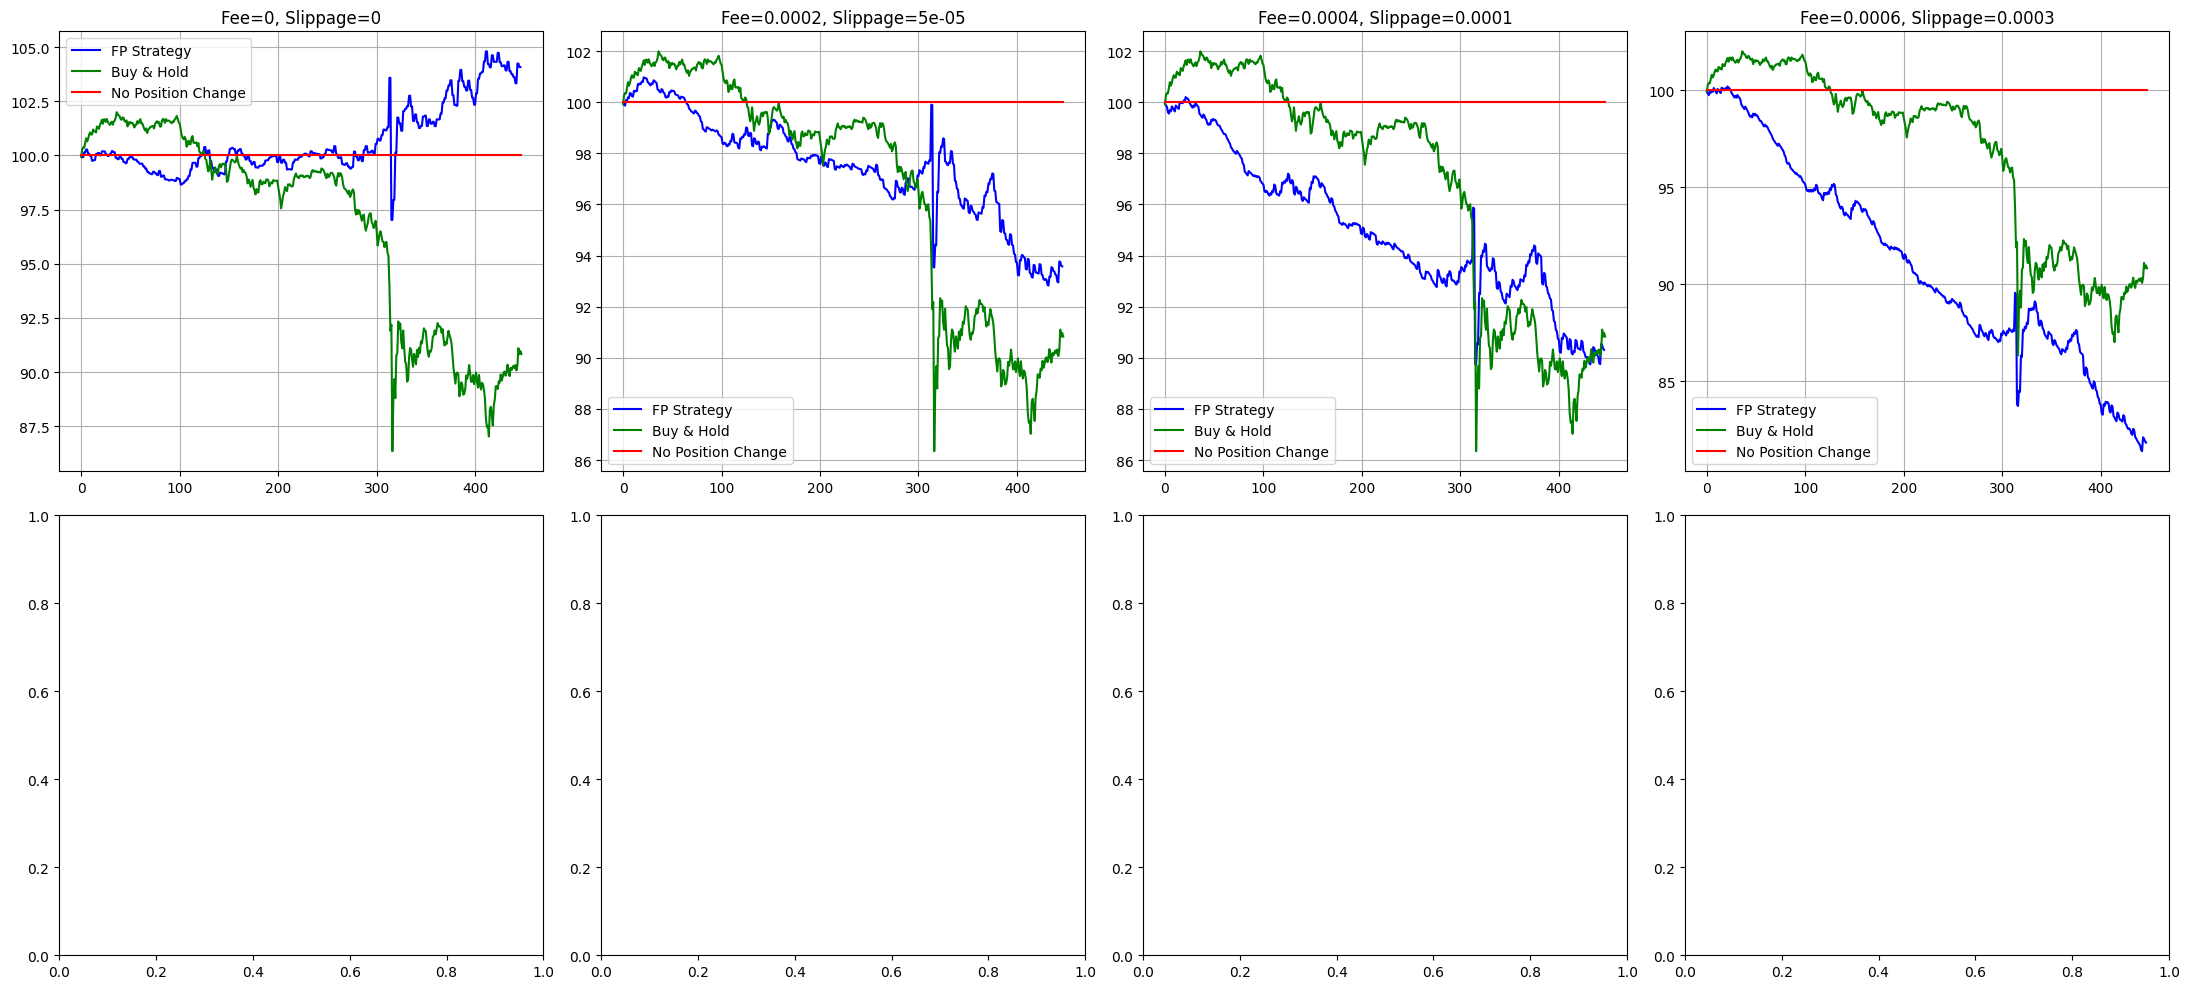


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000           104.07           4.07           90.83                  -9.17    100.0             0.0
0.0002   0.00005            93.58          -6.42           90.83                  -9.17    100.0             0.0
0.0004   0.00010            90.31          -9.69           90.83                  -9.17    100.0             0.0
0.0006   0.00030            81.85         -18.15           90.83                  -9.17    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("BTC_5min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi_t = features['obi'].iloc[t-1]
        dobi_t = features['dobi'].iloc[t-1]
        depth_t = features['depth'].iloc[t-1]
        slope_t = features['queue_slope'].iloc[t-1]
        spread_t = features['spread'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi_t + a3 * dobi_t + a4 * depth_t + a5 * slope_t + a6 * spread_t)
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'queue_slope', 'spread']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:7]
        sigma_params = params[7:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*7 + [0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:7], res[0][7:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+200) for i in range(0, len(df_train)-200, 200)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'queue_slope', 'spread']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'queue_slope', 'spread']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'queue_slope', 'spread']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


/tmp/ipython-input-7-3049133861.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
/tmp/ipython-input-7-3049133861.py:58: RuntimeWarning: overflow encountered in scalar multiply
  mu = (a0 + a1 * x[t-1] + a2 * obi_t + a3 * dobi_t + a4 * depth_t + a5 * slope_t + a6 * spread_t)
/tmp/ipython-input-7-3049133861.py:59: RuntimeWarning: overflow encountered in scalar multiply
  sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
/tmp/ipython-input-7-3049133861.py:60: RuntimeWarning: invalid value encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
/tmp/ipython-input-7-3049133861.py:60: RuntimeWarning: overflow encountered in scalar add
  x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
/tmp/ipython-input-7-3049133861.py:60: RuntimeWarning: overflow encountered in scalar multiply
  x[t] = x[t-1] + mu * dt + s

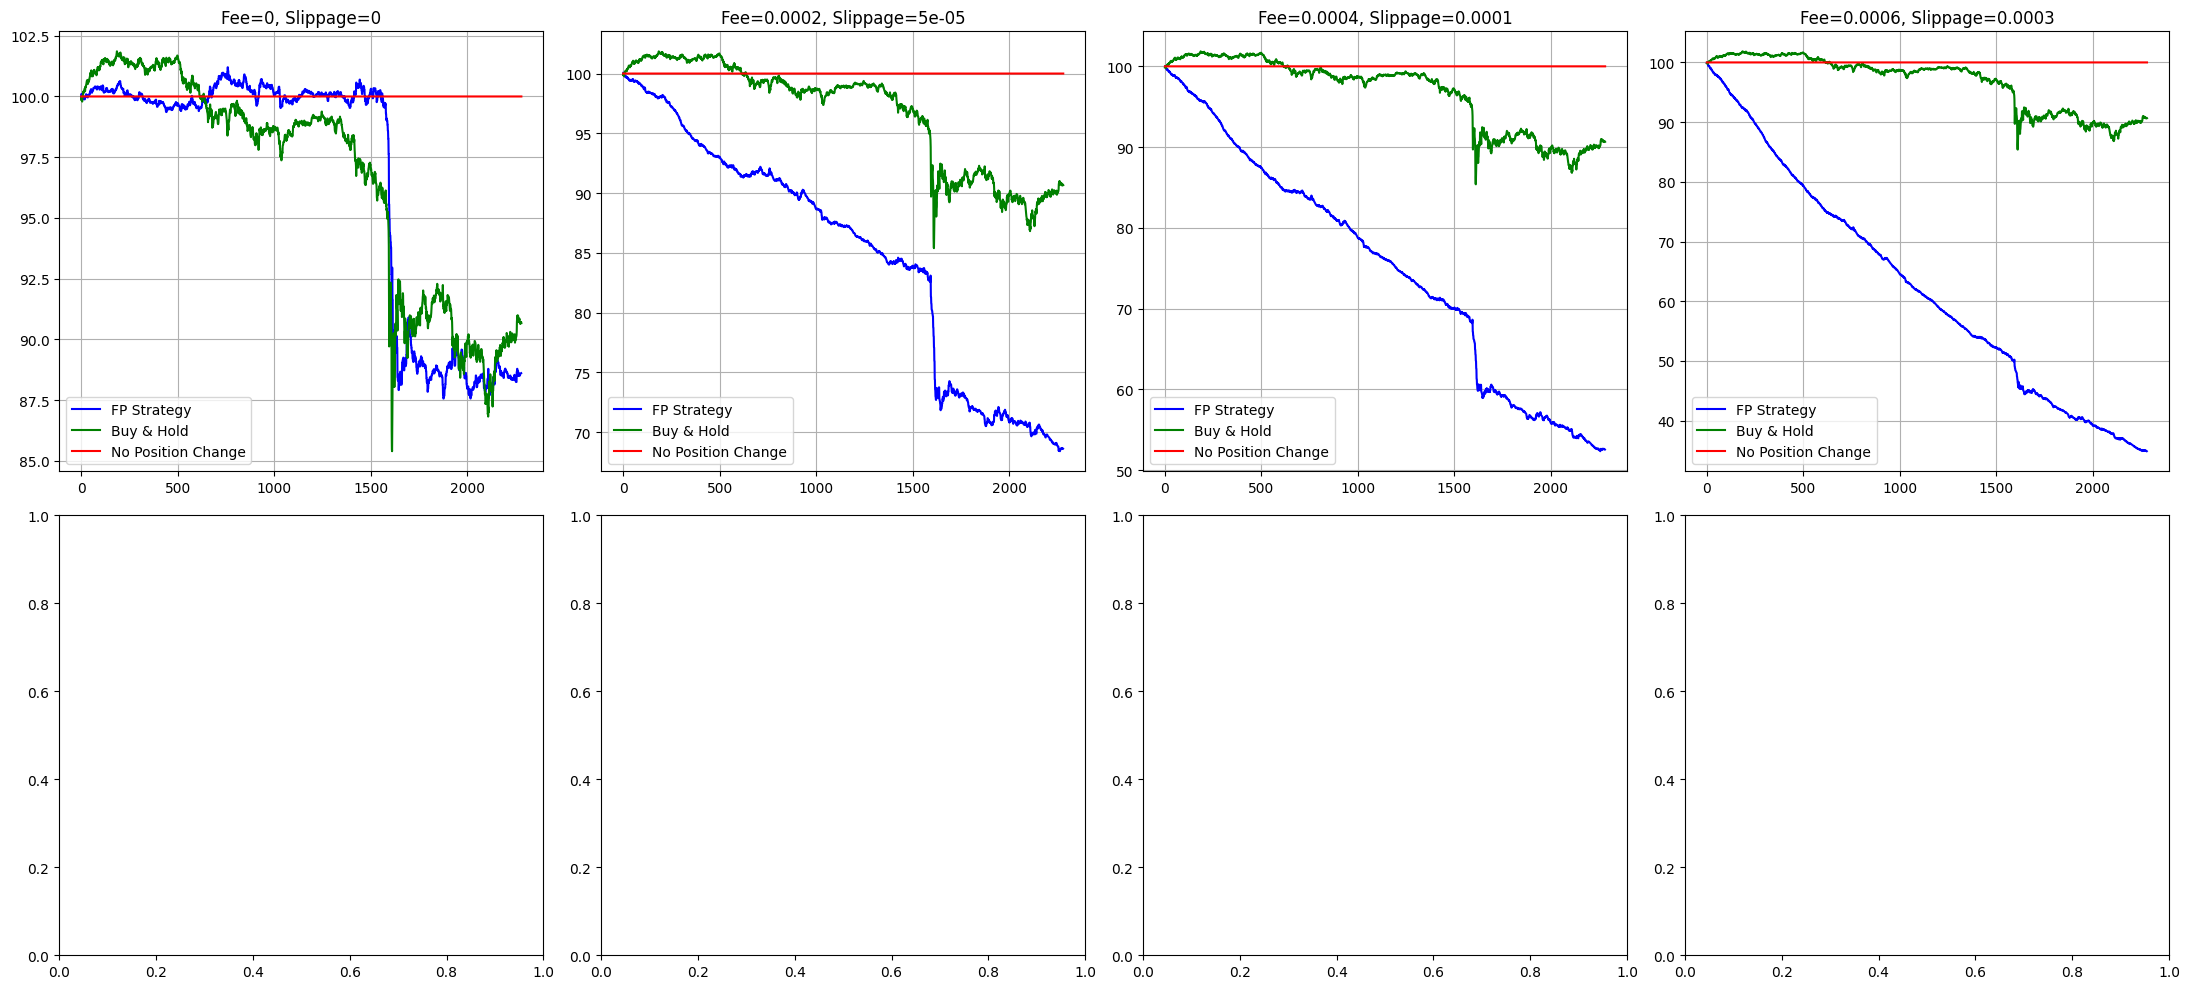


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            88.61         -11.39           90.67                  -9.33    100.0             0.0
0.0002   0.00005            68.62         -31.38           90.67                  -9.33    100.0             0.0
0.0004   0.00010            52.57         -47.43           90.67                  -9.33    100.0             0.0
0.0006   0.00030            34.87         -65.13           90.67                  -9.33    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("BTC_1min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope'] = df['bids_notional_0'] - df['bids_notional_5']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi_t = features['obi'].iloc[t-1]
        dobi_t = features['dobi'].iloc[t-1]
        depth_t = features['depth'].iloc[t-1]
        slope_t = features['queue_slope'].iloc[t-1]
        spread_t = features['spread'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi_t + a3 * dobi_t + a4 * depth_t + a5 * slope_t + a6 * spread_t)
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'queue_slope', 'spread']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:7]
        sigma_params = params[7:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*7 + [0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:7], res[0][7:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+500) for i in range(0, len(df_train)-500, 500)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'queue_slope', 'spread']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'queue_slope', 'spread']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'queue_slope', 'spread']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


/tmp/ipython-input-2-3620304626.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


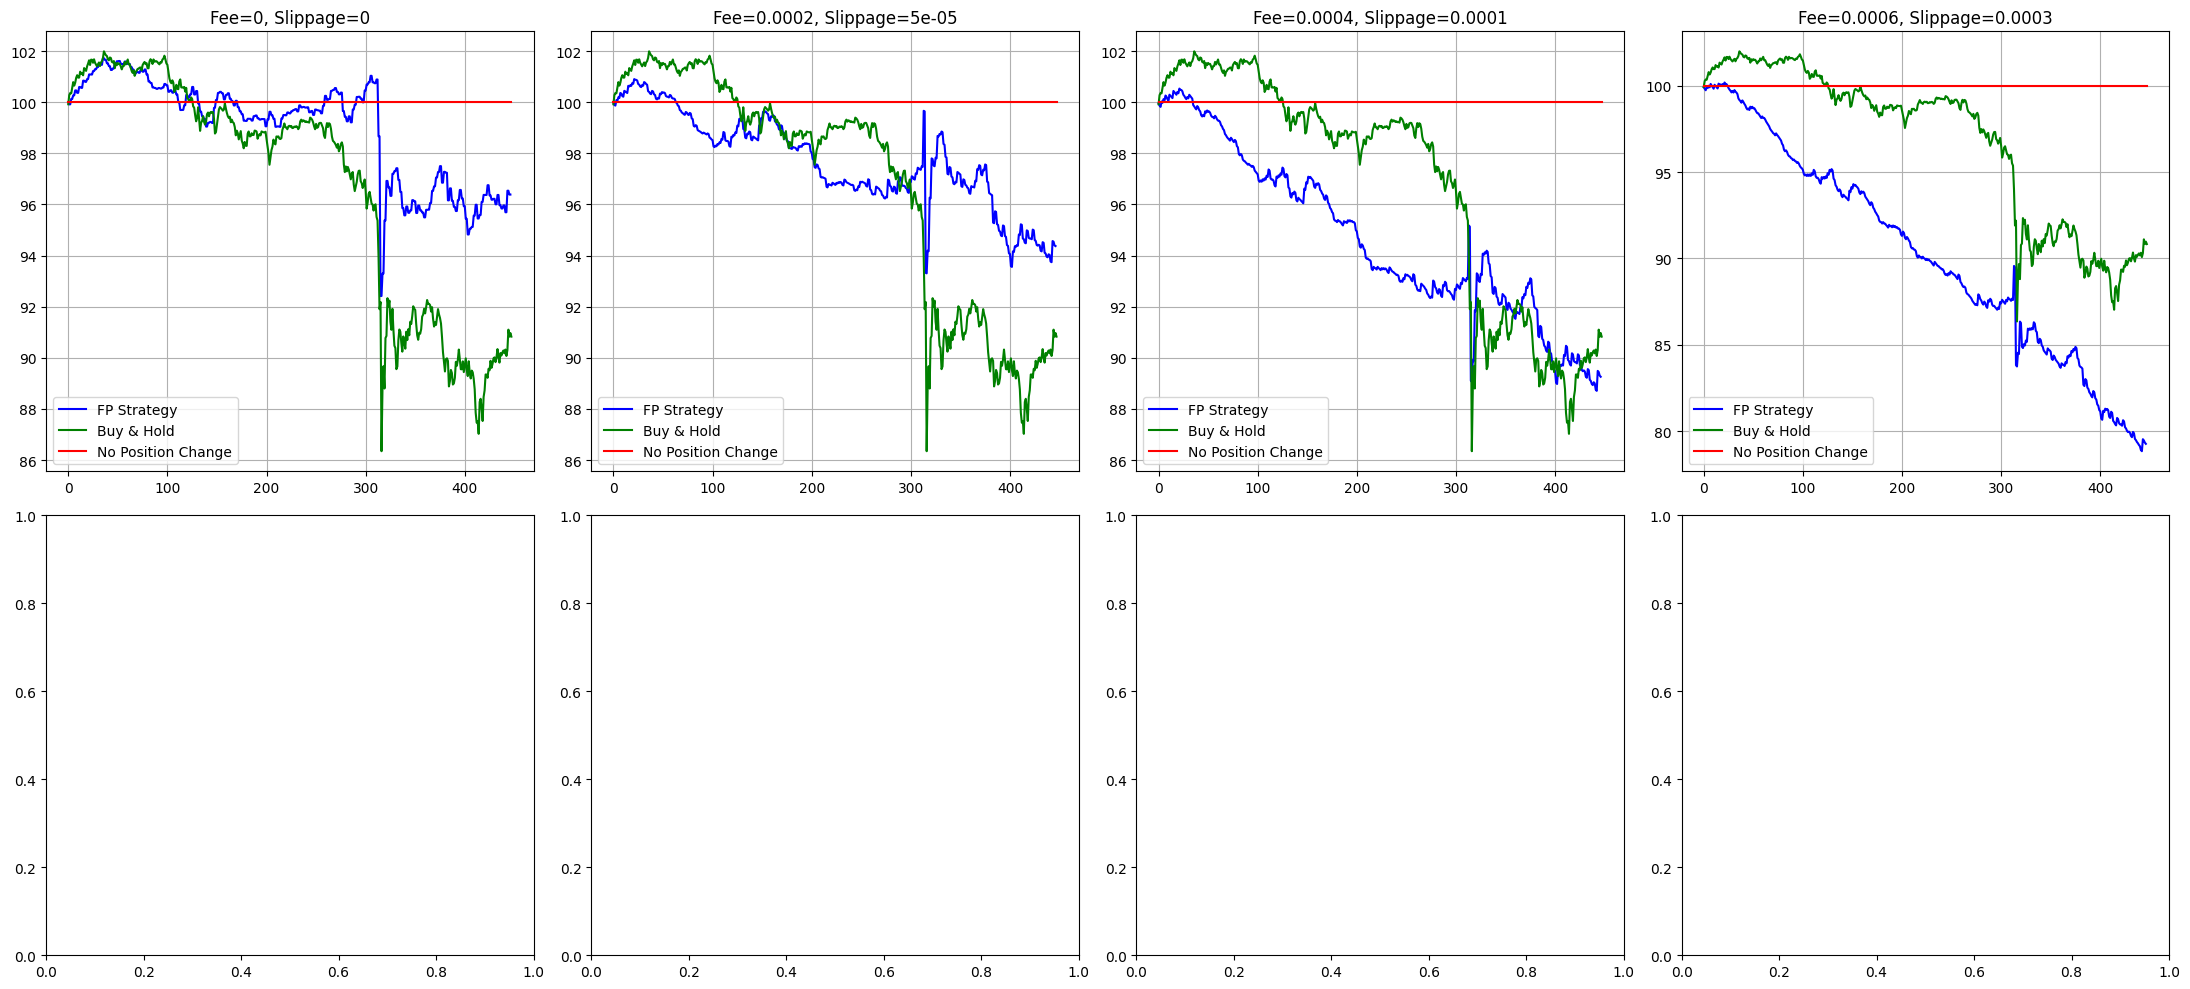


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            96.39          -3.61           90.83                  -9.17    100.0             0.0
0.0002   0.00005            94.37          -5.63           90.83                  -9.17    100.0             0.0
0.0004   0.00010            89.26         -10.74           90.83                  -9.17    100.0             0.0
0.0006   0.00030            79.26         -20.74           90.83                  -9.17    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("BTC_5min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]

df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = df['dobi'].abs()

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6, a7, a8, a9 = mu_params
    b0, b1, b2 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi = features['obi'].iloc[t-1]
        dobi = features['dobi'].iloc[t-1]
        depth = features['depth'].iloc[t-1]
        net_slope = features['net_queue_slope'].iloc[t-1]
        spread = features['spread'].iloc[t-1]
        depth_var = features['depth_variance'].iloc[t-1]
        abs_dobi = features['abs_dobi'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi + a3 * dobi + a4 * depth + a5 * net_slope + a6 * spread + a7 * depth_var + a8 * abs_dobi + a9 * np.sign(x[t-1]))
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]) + b2 * spread)
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:10]
        sigma_params = params[10:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*10 + [0.005, 0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:10], res[0][10:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+200) for i in range(0, len(df_train)-200, 200)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


/tmp/ipython-input-3-97513049.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)


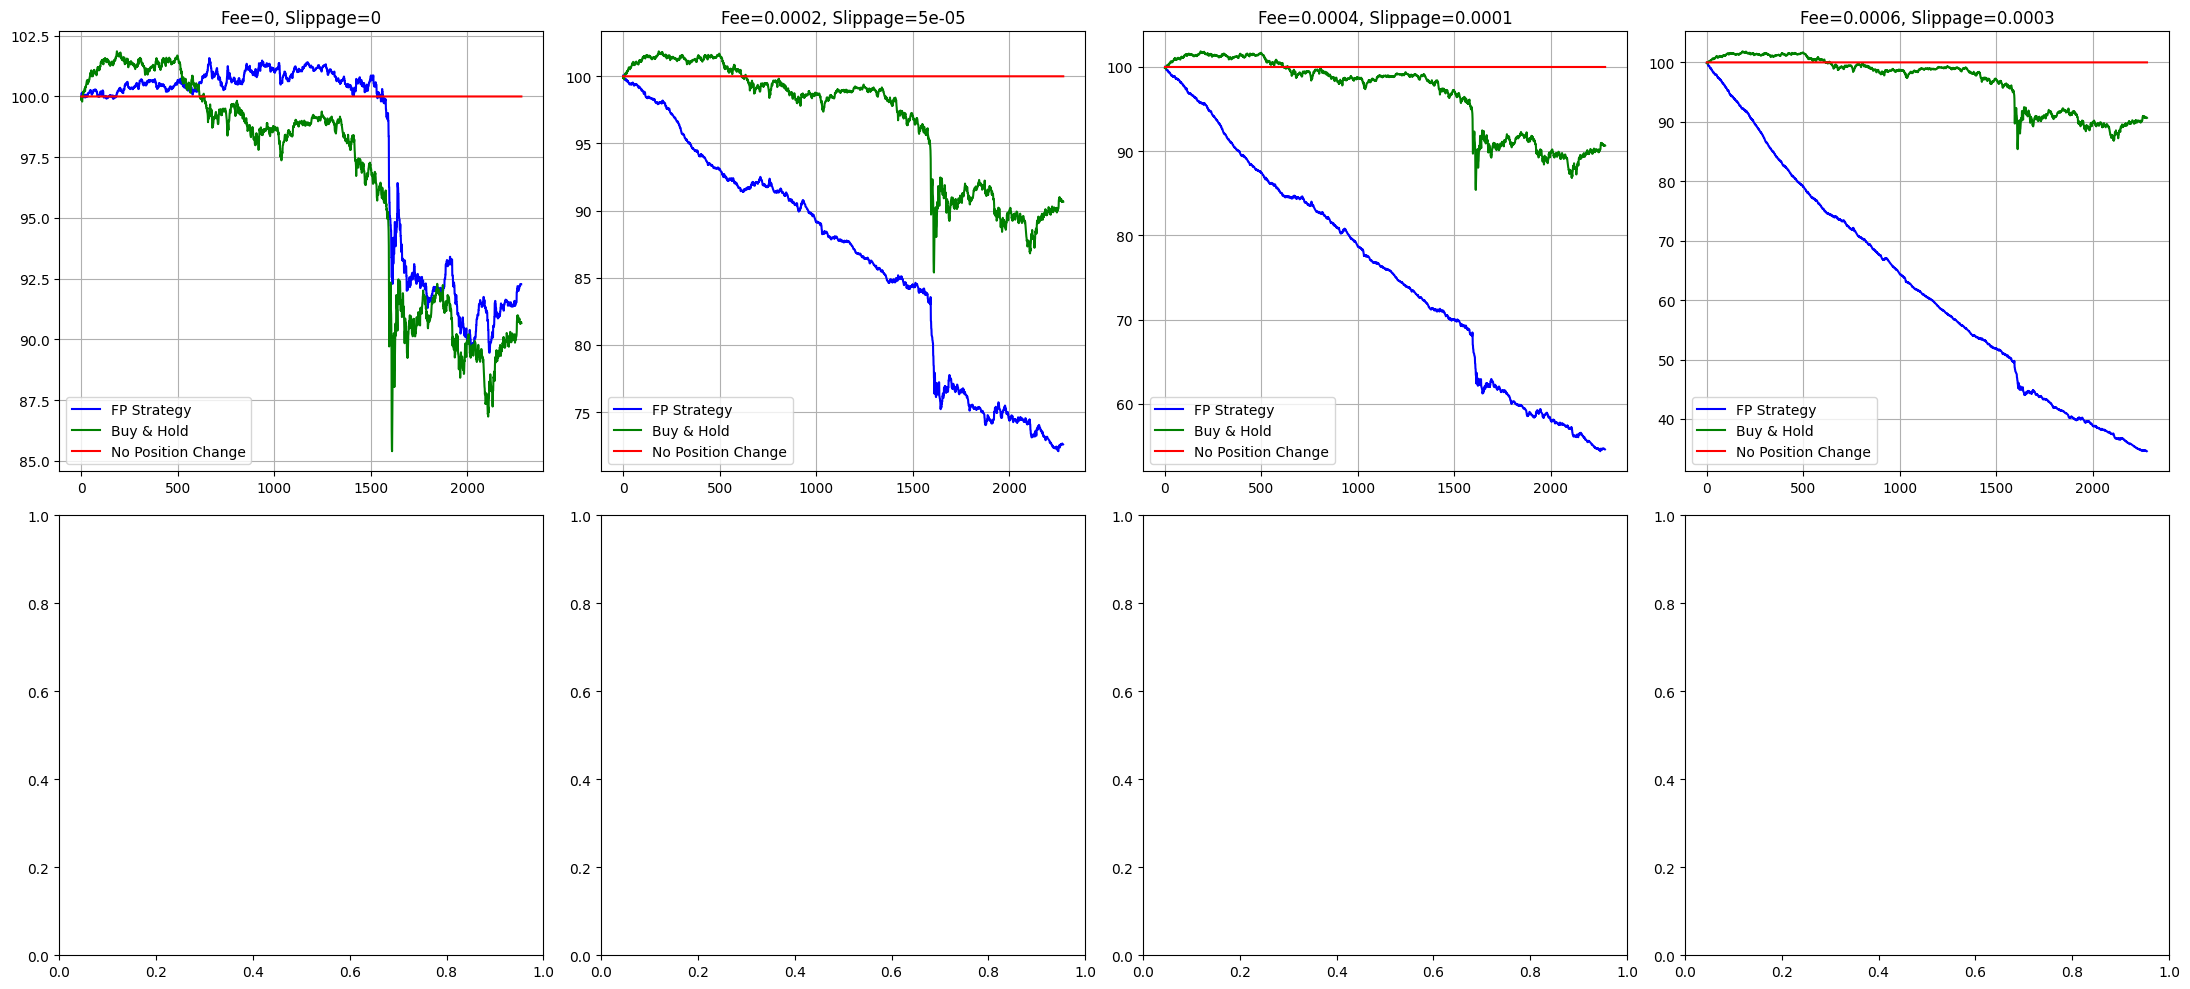


Final Portfolio Values and Returns for Different Fee/Slippage Configurations:
   Fee  Slippage  FP Strategy ($)  FP Return (%)  Buy & Hold ($)  Buy & Hold Return (%)  NPC ($)  NPC Return (%)
0.0000   0.00000            92.26          -7.74           90.67                  -9.33    100.0             0.0
0.0002   0.00005            72.59         -27.41           90.67                  -9.33    100.0             0.0
0.0004   0.00010            54.58         -45.42           90.67                  -9.33    100.0             0.0
0.0006   0.00030            34.58         -65.42           90.67                  -9.33    100.0             0.0


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("BTC_1min.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['net_queue_slope'] = (df['bids_notional_0'] - df['bids_notional_5']) - (df['asks_notional_0'] - df['asks_notional_5'])
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
df['depth_variance'] = df[bid_cols + ask_cols].std(axis=1)
df['abs_dobi'] = np.abs(df['dobi'])

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        obi_t = features['obi'].iloc[t-1]
        dobi_t = features['dobi'].iloc[t-1]
        depth_t = features['depth'].iloc[t-1]
        slope_t = features['net_queue_slope'].iloc[t-1]
        spread_t = features['spread'].iloc[t-1]
        dv_t = features['depth_variance'].iloc[t-1]
        abs_dobi_t = features['abs_dobi'].iloc[t-1]
        mu = (a0 + a1 * x[t-1] + a2 * obi_t + a3 * dobi_t + a4 * depth_t + a5 * slope_t + a6 * spread_t)
        sigma = np.abs(b0 + b1 * (dv_t + abs_dobi_t))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:7]
        sigma_params = params[7:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*7 + [0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:7], res[0][7:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+500) for i in range(0, len(df_train)-500, 500)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'net_queue_slope', 'spread', 'depth_variance', 'abs_dobi']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


In [ ]:
import pandas as pd
import numpy as np
from cma import fmin
import matplotlib.pyplot as plt

np.random.seed(42)
random_seed = 42

df = pd.read_csv("BTC_1sec.csv")
for j in range(15):
    df[f'bid_price_{j}'] = df['midpoint'] - df[f'bids_distance_{j}']
    df[f'ask_price_{j}'] = df['midpoint'] + df[f'asks_distance_{j}']

bid_cols = [f"bids_notional_{i}" for i in range(15)]
ask_cols = [f"asks_notional_{i}" for i in range(15)]
df['obi'] = (df[bid_cols].sum(axis=1) - df[ask_cols].sum(axis=1)) / (df[bid_cols].sum(axis=1) + df[ask_cols].sum(axis=1) + 1e-8)
df['dobi'] = df['obi'].diff().fillna(0)
df['depth'] = df[bid_cols + ask_cols].sum(axis=1)
df['queue_slope_bid'] = df['bids_notional_0'] - df['bids_notional_5']
df['queue_slope_ask'] = df['asks_notional_0'] - df['asks_notional_5']
df['net_queue_slope'] = df['queue_slope_bid'] - df['queue_slope_ask']
df['spread'] = np.where((df['asks_notional_0'] > 0) & (df['bids_notional_0'] > 0), df['ask_price_0'] - df['bid_price_0'], np.nan)
df['spread'] = df['spread'].fillna(method='ffill').fillna(0)

train_end = int(len(df) * 0.6)
cv_end = int(len(df) * 0.8)
df_train = df.iloc[:train_end].copy().reset_index(drop=True)
df_cv = df.iloc[train_end:cv_end].copy().reset_index(drop=True)
df_test = df.iloc[cv_end:].copy().reset_index(drop=True)

for d in [df_train, df_cv, df_test]:
    d['log_mid'] = np.log(d['midpoint'])
    d['returns'] = d['log_mid'].diff().fillna(0)

def trading_strategy(signal, threshold):
    positions = np.where(signal > threshold, 1, np.where(signal < -threshold, -1, 0))
    trades = np.diff(positions, prepend=0)
    return positions, trades

def apply_trading_costs(positions, trades, returns, fee, slip):
    raw_pnl = positions[:-1] * returns[1:len(positions)]
    trade_mask = np.abs(trades[1:len(positions)]) > 0
    costs = np.zeros_like(raw_pnl)
    costs[trade_mask] = fee + slip
    net_pnl = raw_pnl - costs
    return net_pnl

def simulate_fp(mu_params, sigma_params, x0, features, timesteps, dt):
    a0, a1, a2, a3, a4, a5, a6, a7 = mu_params
    b0, b1 = sigma_params
    x = np.zeros(timesteps)
    x[0] = x0
    rng = np.random.RandomState(random_seed)
    for t in range(1, timesteps):
        f = features.iloc[t-1]
        mu = a0 + a1 * x[t-1] + a2 * f['obi'] + a3 * f['dobi'] + a4 * f['depth'] + a5 * f['spread'] + a6 * f['queue_slope_bid'] + a7 * f['queue_slope_ask']
        sigma = np.abs(b0 + b1 * np.abs(x[t-1]))
        x[t] = x[t-1] + mu * dt + sigma * np.sqrt(dt) * rng.randn()
    return x

def optimize_threshold(signal, returns, fee, slip):
    thresholds = np.linspace(0.001, 0.01, 15)
    best_pnl = -np.inf
    best_thresh = 0.005
    for t in thresholds:
        pos, trades = trading_strategy(signal, t)
        pnl = np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
        if pnl > best_pnl:
            best_pnl = pnl
            best_thresh = t
    return best_thresh

def train_fp_model(df_slice, fee, slip):
    returns = df_slice['returns'].values
    features = df_slice[['obi', 'dobi', 'depth', 'spread', 'queue_slope_bid', 'queue_slope_ask']]
    x_init = 0.0
    dt = 1.0
    def objective(params):
        mu_params = params[:8]
        sigma_params = params[8:]
        signal = simulate_fp(mu_params, sigma_params, x_init, features, len(returns), dt)
        pos, trades = trading_strategy(signal, 0.005)
        return -np.sum(apply_trading_costs(pos, trades, returns, fee, slip))
    res = fmin(objective, [0]*8 + [0.005, 0.005], sigma0=0.2, options={'seed':random_seed, 'verb_disp':0})
    return res[0][:8], res[0][8:]

fees = [0, 0.0002, 0.0004, 0.0006]
slippages = [0, 0.00005, 0.0001, 0.0003]
results = []
fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for idx, (fee, slip) in enumerate(zip(fees, slippages)):
    train_segments = [(i, i+200) for i in range(0, len(df_train)-200, 200)]
    segment_models = []
    segment_thresholds = []
    for start, end in train_segments:
        mu_p, sigma_p = train_fp_model(df_train.iloc[start:end], fee, slip)
        signal = simulate_fp(mu_p, sigma_p, 0.0, df_train.iloc[start:end][['obi', 'dobi', 'depth', 'spread', 'queue_slope_bid', 'queue_slope_ask']], end-start, 1.0)
        threshold = optimize_threshold(signal, df_train.iloc[start:end]['returns'].values, fee, slip)
        segment_models.append((mu_p, sigma_p))
        segment_thresholds.append(threshold)

    window_size = 3
    cv_returns = df_cv['returns'].values
    selected_model_indices = []
    for start in range(0, len(cv_returns) - window_size, window_size):
        end = start + window_size
        best_pnl = -np.inf
        best_index = 0
        for i, (mu_p, sigma_p) in enumerate(segment_models):
            signal = simulate_fp(mu_p, sigma_p, 0.0, df_cv.iloc[start:end][['obi', 'dobi', 'depth', 'spread', 'queue_slope_bid', 'queue_slope_ask']], window_size, 1.0)
            pos, trades = trading_strategy(signal, segment_thresholds[i])
            pnl = np.sum(apply_trading_costs(pos, trades, cv_returns[start:end], fee, slip))
            if pnl > best_pnl:
                best_pnl = pnl
                best_index = i
        selected_model_indices.append(best_index)

    test_returns = df_test['returns'].values
    test_features = df_test[['obi', 'dobi', 'depth', 'spread', 'queue_slope_bid', 'queue_slope_ask']]
    test_positions = []
    test_trades = []
    for i, start in enumerate(range(0, len(test_returns) - window_size + 1, window_size)):
        end = start + window_size
        model_index = selected_model_indices[min(i, len(selected_model_indices)-1)]
        mu_p, sigma_p = segment_models[model_index]
        threshold = segment_thresholds[model_index]
        signal = simulate_fp(mu_p, sigma_p, 0.0, test_features.iloc[start:end], window_size, 1.0)
        pos, trades = trading_strategy(signal, threshold)
        test_positions.append(pos)
        test_trades.append(trades)

    if not test_positions:
        continue

    fp_positions = np.concatenate([p[:-1] if len(p) > 1 else p for p in test_positions])
    fp_trades = np.concatenate([t[:-1] if len(t) > 1 else t for t in test_trades])
    fp_returns = test_returns[1:len(fp_positions)+1]

    min_length = min(len(fp_positions), len(fp_returns))
    fp_positions = fp_positions[:min_length]
    fp_trades = fp_trades[:min_length]
    fp_returns = fp_returns[:min_length]

    initial_investment = 100
    fp_net_returns = apply_trading_costs(fp_positions, fp_trades, fp_returns, fee, slip)
    fp_pnl = initial_investment * np.exp(np.cumsum(fp_net_returns))

    bh_returns = test_returns[1:min_length+1]
    bh_pnl = initial_investment * np.exp(np.cumsum(bh_returns))

    first_position = fp_positions[0] if len(fp_positions) > 0 else 0
    initial_trade_cost = (fee + slip) if first_position != 0 else 0
    npc_returns = first_position * bh_returns - initial_trade_cost
    npc_pnl = initial_investment * np.exp(np.cumsum(npc_returns))

    ax = axes[idx]
    ax.plot(fp_pnl, label='FP Strategy', color='blue')
    ax.plot(bh_pnl, label='Buy & Hold', color='green')
    ax.plot(npc_pnl, label='No Position Change', color='red')
    ax.set_title(f"Fee={fee}, Slippage={slip}")
    ax.grid(True)
    ax.legend()

    results.append({
        "Fee": fee,
        "Slippage": slip,
        "FP Strategy ($)": round(fp_pnl[-1], 2),
        "FP Return (%)": round((fp_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "Buy & Hold ($)": round(bh_pnl[-1], 2),
        "Buy & Hold Return (%)": round((bh_pnl[-1] - initial_investment) / initial_investment * 100, 2),
        "NPC ($)": round(npc_pnl[-1], 2),
        "NPC Return (%)": round((npc_pnl[-1] - initial_investment) / initial_investment * 100, 2),
    })

plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nFinal Portfolio Values and Returns for Different Fee/Slippage Configurations:")
print(results_df.to_string(index=False))


/tmp/ipython-input-4-247870957.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['spread'] = df['spread'].fillna(method='ffill').fillna(0)
